# Análise de Séries Temporais da Evolução da Energia Elétrica Brasileira entre 2000 e 2020

## DESCRIÇÃO DO PROJETO

A capacidade energética de um país é vital para o crescimento econômico de país. Em um mundo com uma demanda energética cada vez maior, cada país precisará expandir sua matriz energética - em especial a elétrica - de forma contínua. Entretanto, medidas para conter o Aquecimento Global estão sendo cada vez mais incisivas, tentando minimizar a emissão de gases poluentes. Dessa forma, a expansão da matriz elétrica de cada país deve ser realizada utilizando, de preferência, fontes renováveis e pouco poluentes a fim de garantir um mundo melhor para as próximas gerações.

O Brasil é conhecido mundialmente pela sua grande diversidade e disponibiliadade de recursos naturais, o que permite que sua matriz elétrica seja dominada predominantemente por fontes renováveis. Entretando, a crescente demanda energética tem causado problemas na garantia do fornecimento de energia para a população, problemas esses que podem se agravar futuramente. Portanto, esse trabalho tem o intuito de avaliar o crescimento da energia elétrica brasileira entre 2000 e 2020 a partir dos dados de energia despachada no SIN (Sistema Interligado Nacional). 

Esse projeto possui dois principais objetivos:

- Análise Exploratória dos Dados (EDA) do conjunto de dados, com enfoque maior na Energia Total Despachada de energia;
- Criação de um modelo preditivo do comportamento da Energia Total utilizando o modelo SARIMA.


## 1. IMPORTAÇÕES

Segue abaixo as bibliotecas importadas para a realização desse projeto. Foram criadas classes em arquivos ".py" separados que agrupam as funções criadas para a realização do projeto. Esses arquivos estão anexados em conjunto com o projeto no [GitHub](https://github.com/LuanRD/energia-eletrica).

In [1]:
import pandas as pd

# Classe com funções para Análise Exploratória dos Dados
from classes_eda import Graficos, Correlacao, Stats, Nulos

# Classe com funções para criação do modelo SARIMA
from classe_sarima import Sarima

## 2. COLETA DOS DADOS

Os dados utilizados nesse projeto foram coletados através do Portal de Dados Abertos disponibilizado pela ANEEL - Agência Nacional de Energia Elétrica. Os dados compreendem o histórico do volume de energia elétrica produzida no Brasil despachada no Sistema Interligado Nacional (SIN) entre janeiro de 2000 até junho de 2020 (dados mais atualizados disponíveis visto que esse conjunto de dados foi descontinuado). O portal pode ser acessado através desse [link](https://dados.gov.br/dataset/geracao-por-fonte1).

In [2]:
# Upload e leitura dos dados do projeto
dados = pd.read_csv('GeracaoFonte.csv')
dados.head()

,ideGeracaoFonte,nomFonteGeracao,mdaEnergiaDespachadaGWh,mesReferencia,anoReferencia,dthProcessamento
0,1,Hidreletricas exclusive Itaipu,21074.749841,1,2000,NaN
1,2,Itaipu,6523.780292,1,2000,NaN
2,3,Oleo Diesel / Combustivel,112.026593,1,2000,NaN
3,4,Gas Natural,512.536500,1,2000,NaN
4,5,Carvao,772.954908,1,2000,NaN


Segue abaixo as descrições de cada variável disponibilizada pela ANEEL no seu Dicionário de Dados, que pode ser acessado pelo [link](https://www.aneel.gov.br/documents/656835/15191504/DD_IG_1_3.pdf/f4be6c6e-4336-0f51-c6d3-f75d184e6e92). Também foram especificados os tipos de cada uma das variáveis.


| Variável | Tipo | Descrição| 
|:------:|:------:|:------:|
|   IdeGeracaoFonte  | int64 | Identificador Geração Fonte|
|   NomFonteGeracao  | object | Nome da fonte de geração de energia elétrica|
|   MdaEnergiaDespachadaGWh  | float64 | Quantidade de Carga de energia despachada pelo sistema interligado e pelas geradoras isoladas|
|   MesReferencia  | int64 | Mês de referência da coleta da carga de energia despachada em GWh|
|   AnoReferencia  | int64 | Ano de referência da coleta da carga de energia despachada em GWh|
|   DthProcessamento  | object | Data e hora do processamento de carga automática.|

## 3. TRATAMENTO DOS DADOS

### 3.1. Tratamento Inicial dos Dados

O tratamento dos dados é realizado como primeira medida antes de se poder inferir informações a partir dos dados, de modo que é necessário que eles sejam adequados para análise e aplicação dos modelos de Séries Temporais. É importante muito cuidado nesta etapa visto que dados com tratamentos inadequados podem gerar análises e modelos incorretos, comprometendo quaisquer conclusões realizadas.

In [3]:
# Somatório dos valores nulos de cada variável
dados.isna().sum()

ideGeracaoFonte               0
nomFonteGeracao               0
mdaEnergiaDespachadaGWh      71
mesReferencia                 0
anoReferencia                 0
dthProcessamento           2364
dtype: int64

Eliminação da coluna "dthProcessamento" pela forte predominância de valores nulos e da coluna "ideGeracaoFonte" pois o DataFrame do Pandas já insere índices para cada valor.
Além disso, a posterior exclusão de linhas tornaria os valores fornecidos por "ideGeracaoFonte" incoerentes com o estado do DataFrame.

In [4]:
# Eliminação das colunas selecionadas
dados.drop(['dthProcessamento', 'ideGeracaoFonte'], axis=1, inplace=True)
dados

,nomFonteGeracao,mdaEnergiaDespachadaGWh,mesReferencia,anoReferencia
0,Hidreletricas exclusive Itaipu,21074.749841,1,2000
1,Itaipu,6523.780292,1,2000
2,Oleo Diesel / Combustivel,112.026593,1,2000
3,Gas Natural,512.536500,1,2000
4,Carvao,772.954908,1,2000
...,...,...,...,...
2491,Carvao,610.747200,6,2020
2492,Biomassas,1030.651200,6,2020
2493,Nuclear,1037.253600,6,2020
2494,Residuos Processos Industriais,765.554400,6,2020


Como os dados tem comportamento variando com o tempo, é necessário que haja uma formatação que adeque a variável de data no formato aceito pelo Pandas (ano-mês-dia / 2000-01-01). Dessa forma, criou-se uma variável referente ao dia (day), onde o dia 1 foi arbitrariamente escolhido, visto que os dados foram disponibilizados mensalmente.

In [5]:
# Substituição dos nomes das colunas com dados temporais para "year" e "month"
dados.rename(columns = {'mesReferencia': 'month', 'anoReferencia': 'year'}, inplace=True)

# Criação da coluna "day"
day = pd.Series(1 for x in range(len(dados)))
dados['day'] = day.values

# Agregamento dos dados referentes ao dia e criação da coluna "date"
dados['date'] = pd.to_datetime(dados[['year', 'month', 'day']])

# Reset do index para adequar-se à quantidade de variáveis presentes no dataframe
dados = dados.set_index('date', drop=True)
dados.head(5)

,nomFonteGeracao,mdaEnergiaDespachadaGWh,month,year,day
date,,,,,
2000-01-01,Hidreletricas exclusive Itaipu,21074.749841,1,2000,1
2000-01-01,Itaipu,6523.780292,1,2000,1
2000-01-01,Oleo Diesel / Combustivel,112.026593,1,2000,1
2000-01-01,Gas Natural,512.536500,1,2000,1
2000-01-01,Carvao,772.954908,1,2000,1


Para facilitar as análises que serão realizadas durante este trabalho, o DataFrame será disposto de forma que cada Fonte de Geração será disposta em uma coluna. 

Primeiramente, serão eliminadas as colunas referentes ao dia, mês e ano, visto que elas já estão indicadas através da variável date.

In [6]:
# Eliminação das colunas selecionadas
dados.drop(['day', 'month', 'year'], axis=1, inplace=True)
dados

,nomFonteGeracao,mdaEnergiaDespachadaGWh
date,,
2000-01-01,Hidreletricas exclusive Itaipu,21074.749841
2000-01-01,Itaipu,6523.780292
2000-01-01,Oleo Diesel / Combustivel,112.026593
2000-01-01,Gas Natural,512.536500
2000-01-01,Carvao,772.954908
...,...,...
2020-06-01,Carvao,610.747200
2020-06-01,Biomassas,1030.651200
2020-06-01,Nuclear,1037.253600


Agora, os dados serão pivotados para que eles sejam rearranjados da forma desejada.

In [7]:
# Pivoteamento das linhas para rearranjo do DataFrame
dados = dados.pivot(columns='nomFonteGeracao', values='mdaEnergiaDespachadaGWh')
dados

nomFonteGeracao,Biomassas,Carvao,Energia produzida fora do SIN,Eolicas,Gas Natural,Hidreletricas exclusive Itaipu,Itaipu,Nuclear,Oleo Diesel / Combustivel,Residuos Processos Industriais,Solar Fotovoltaica
date,,,,,,,,,,,
2000-01-01,0.00000,772.954908,NaN,0.00000,512.536500,21074.749841,6523.780292,418.609402,112.026593,0.00000,NaN
2000-02-01,0.00000,726.482505,NaN,0.00000,580.842549,20519.823366,6362.831799,400.617872,69.214905,0.00000,NaN
2000-03-01,0.00000,685.798458,20670.975,0.00000,513.065176,21184.922627,7593.289824,400.187101,78.197350,0.00000,NaN
2000-04-01,358.88560,0.000000,0.000,0.00000,675.601700,7128.300200,39.287100,0.000000,337.403200,0.00000,NaN
2000-05-01,0.00000,725.874700,NaN,0.00000,503.225500,21986.323500,6814.969400,0.000000,101.455500,0.00000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,309.88008,1000.854960,0.000,2710.30752,3349.402560,32612.889600,5646.801120,948.641040,46.534560,838.10232,357.36816
2020-03-01,451.83864,643.321920,0.000,2215.23768,2616.893520,35229.709440,5294.795040,1282.120320,84.220800,832.03008,419.48208
2020-04-01,759.34080,202.917600,0.000,3039.06240,2068.552800,28373.400000,3886.149600,1358.755200,124.992000,759.37680,438.44400


Após o pivoteamento, é interessante recuperar as informações de mês e ano de cada dado enquanto "date" é mantido como index. 

In [8]:
# Resetar o indexamento
dados.reset_index(inplace=True, drop=False)

# Criação das variáveis 'month' e 'year' a partir de 'date'
dados['month'] = pd.DatetimeIndex(dados['date']).month
dados['year'] = pd.DatetimeIndex(dados['date']).year

# Retornar 'date' como index
dados = dados.set_index('date', drop=False)

# Eliminação da coluna 'date' residual
dados.drop(['date'], axis=1, inplace=True)
dados.head(5)

nomFonteGeracao,Biomassas,Carvao,Energia produzida fora do SIN,Eolicas,Gas Natural,Hidreletricas exclusive Itaipu,Itaipu,Nuclear,Oleo Diesel / Combustivel,Residuos Processos Industriais,Solar Fotovoltaica,month,year
date,,,,,,,,,,,,,
2000-01-01,0.0000,772.954908,NaN,0.0,512.536500,21074.749841,6523.780292,418.609402,112.026593,0.0,NaN,1,2000
2000-02-01,0.0000,726.482505,NaN,0.0,580.842549,20519.823366,6362.831799,400.617872,69.214905,0.0,NaN,2,2000
2000-03-01,0.0000,685.798458,20670.975,0.0,513.065176,21184.922627,7593.289824,400.187101,78.197350,0.0,NaN,3,2000
2000-04-01,358.8856,0.000000,0.000,0.0,675.601700,7128.300200,39.287100,0.000000,337.403200,0.0,NaN,4,2000
2000-05-01,0.0000,725.874700,NaN,0.0,503.225500,21986.323500,6814.969400,0.000000,101.455500,0.0,NaN,5,2000


As Fontes de Geração presentes no DataFrame serão padronizadas para evitar problemas na hora de selecionar alguma variável, normalmente ocasionados pela presença de espaços e caracteres especiais. Além disso, foram feitas traduções e simplificações nos nomes de algumas variáveis.

In [9]:
# Mudanças nos nomes dos dados
dados = dados.rename(columns={
    'Energia produzida fora do SIN':'Fora_do_SIN',
    'Gas Natural': 'Gas_Natural',
    'Hidreletricas exclusive Itaipu': 'Hidreletricas_exceto_Itaipu',
    'Oleo Diesel / Combustivel': 'Oleo',
    'Residuos Processos Industriais': 'Residuos_Industriais',
    'Solar Fotovoltaica': 'Solar_Fotovoltaica'
})
dados

nomFonteGeracao,Biomassas,Carvao,Fora_do_SIN,Eolicas,Gas_Natural,Hidreletricas_exceto_Itaipu,Itaipu,Nuclear,Oleo,Residuos_Industriais,Solar_Fotovoltaica,month,year
date,,,,,,,,,,,,,
2000-01-01,0.00000,772.954908,NaN,0.00000,512.536500,21074.749841,6523.780292,418.609402,112.026593,0.00000,NaN,1,2000
2000-02-01,0.00000,726.482505,NaN,0.00000,580.842549,20519.823366,6362.831799,400.617872,69.214905,0.00000,NaN,2,2000
2000-03-01,0.00000,685.798458,20670.975,0.00000,513.065176,21184.922627,7593.289824,400.187101,78.197350,0.00000,NaN,3,2000
2000-04-01,358.88560,0.000000,0.000,0.00000,675.601700,7128.300200,39.287100,0.000000,337.403200,0.00000,NaN,4,2000
2000-05-01,0.00000,725.874700,NaN,0.00000,503.225500,21986.323500,6814.969400,0.000000,101.455500,0.00000,NaN,5,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,309.88008,1000.854960,0.000,2710.30752,3349.402560,32612.889600,5646.801120,948.641040,46.534560,838.10232,357.36816,2,2020
2020-03-01,451.83864,643.321920,0.000,2215.23768,2616.893520,35229.709440,5294.795040,1282.120320,84.220800,832.03008,419.48208,3,2020
2020-04-01,759.34080,202.917600,0.000,3039.06240,2068.552800,28373.400000,3886.149600,1358.755200,124.992000,759.37680,438.44400,4,2020


Para a análise da Matriz Elétrica Brasileira, a criação de algumas variáveis irá aprofundar a análise. Dessa forma, serão feitos alguns agrupamentos para que eles sejam adicionados ao DataFrame.

Primeiramente, será criada uma coluna com os valores totais de Energia Gerada em cada data.

In [10]:
# Criação da variável "total"
total = dados.sum(axis=1) - dados['month'] - dados['year']

# Adição da variável ao DataFrame
dados = dados.assign(Total=total)
dados

nomFonteGeracao,Biomassas,Carvao,Fora_do_SIN,Eolicas,Gas_Natural,Hidreletricas_exceto_Itaipu,Itaipu,Nuclear,Oleo,Residuos_Industriais,Solar_Fotovoltaica,month,year,Total
date,,,,,,,,,,,,,,
2000-01-01,0.00000,772.954908,NaN,0.00000,512.536500,21074.749841,6523.780292,418.609402,112.026593,0.00000,NaN,1,2000,29414.657538
2000-02-01,0.00000,726.482505,NaN,0.00000,580.842549,20519.823366,6362.831799,400.617872,69.214905,0.00000,NaN,2,2000,28659.812997
2000-03-01,0.00000,685.798458,20670.975,0.00000,513.065176,21184.922627,7593.289824,400.187101,78.197350,0.00000,NaN,3,2000,51126.435535
2000-04-01,358.88560,0.000000,0.000,0.00000,675.601700,7128.300200,39.287100,0.000000,337.403200,0.00000,NaN,4,2000,8539.477800
2000-05-01,0.00000,725.874700,NaN,0.00000,503.225500,21986.323500,6814.969400,0.000000,101.455500,0.00000,NaN,5,2000,30131.848600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,309.88008,1000.854960,0.000,2710.30752,3349.402560,32612.889600,5646.801120,948.641040,46.534560,838.10232,357.36816,2,2020,47820.781920
2020-03-01,451.83864,643.321920,0.000,2215.23768,2616.893520,35229.709440,5294.795040,1282.120320,84.220800,832.03008,419.48208,3,2020,49069.649520
2020-04-01,759.34080,202.917600,0.000,3039.06240,2068.552800,28373.400000,3886.149600,1358.755200,124.992000,759.37680,438.44400,4,2020,41010.991200


Separação dos dados entre Fontes Renováveis e Não Renováveis, excluindo "Fora_do_SIN" e "Residuos_Industriais" dessas classificações.

In [11]:
# Seleção das Fontes Renováveis
fontes_renovaveis = ['Hidreletricas_exceto_Itaipu', 'Itaipu', 'Eolicas', 'Biomassas', 'Solar_Fotovoltaica']
selecao = dados[fontes_renovaveis]

# Criação do agrupamento de Fontes Renováveis 
renovaveis = selecao.sum(axis=1)

# Inserção do agrupamento no DataFrame
dados = dados.assign(Renovavel=renovaveis)

dados

nomFonteGeracao,Biomassas,Carvao,Fora_do_SIN,Eolicas,Gas_Natural,Hidreletricas_exceto_Itaipu,Itaipu,Nuclear,Oleo,Residuos_Industriais,Solar_Fotovoltaica,month,year,Total,Renovavel
date,,,,,,,,,,,,,,,
2000-01-01,0.00000,772.954908,NaN,0.00000,512.536500,21074.749841,6523.780292,418.609402,112.026593,0.00000,NaN,1,2000,29414.657538,27598.530133
2000-02-01,0.00000,726.482505,NaN,0.00000,580.842549,20519.823366,6362.831799,400.617872,69.214905,0.00000,NaN,2,2000,28659.812997,26882.655166
2000-03-01,0.00000,685.798458,20670.975,0.00000,513.065176,21184.922627,7593.289824,400.187101,78.197350,0.00000,NaN,3,2000,51126.435535,28778.212451
2000-04-01,358.88560,0.000000,0.000,0.00000,675.601700,7128.300200,39.287100,0.000000,337.403200,0.00000,NaN,4,2000,8539.477800,7526.472900
2000-05-01,0.00000,725.874700,NaN,0.00000,503.225500,21986.323500,6814.969400,0.000000,101.455500,0.00000,NaN,5,2000,30131.848600,28801.292900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,309.88008,1000.854960,0.000,2710.30752,3349.402560,32612.889600,5646.801120,948.641040,46.534560,838.10232,357.36816,2,2020,47820.781920,41637.246480
2020-03-01,451.83864,643.321920,0.000,2215.23768,2616.893520,35229.709440,5294.795040,1282.120320,84.220800,832.03008,419.48208,3,2020,49069.649520,43611.062880
2020-04-01,759.34080,202.917600,0.000,3039.06240,2068.552800,28373.400000,3886.149600,1358.755200,124.992000,759.37680,438.44400,4,2020,41010.991200,36496.396800


In [12]:
# Seleção das Fontes Não Renováveis
fontes_nao_renovaveis = ['Oleo', 'Gas_Natural', 'Carvao', 'Nuclear']
selecao = dados[fontes_nao_renovaveis]

# Criação do agrupamento de Fontes Renováveis 
nao_renovaveis = selecao.sum(axis=1)

# Inserção do agrupamento no DataFrame
dados = dados.assign(Nao_Renovavel=nao_renovaveis)

dados

nomFonteGeracao,Biomassas,Carvao,Fora_do_SIN,Eolicas,Gas_Natural,Hidreletricas_exceto_Itaipu,Itaipu,Nuclear,Oleo,Residuos_Industriais,Solar_Fotovoltaica,month,year,Total,Renovavel,Nao_Renovavel
date,,,,,,,,,,,,,,,,
2000-01-01,0.00000,772.954908,NaN,0.00000,512.536500,21074.749841,6523.780292,418.609402,112.026593,0.00000,NaN,1,2000,29414.657538,27598.530133,1816.127404
2000-02-01,0.00000,726.482505,NaN,0.00000,580.842549,20519.823366,6362.831799,400.617872,69.214905,0.00000,NaN,2,2000,28659.812997,26882.655166,1777.157832
2000-03-01,0.00000,685.798458,20670.975,0.00000,513.065176,21184.922627,7593.289824,400.187101,78.197350,0.00000,NaN,3,2000,51126.435535,28778.212451,1677.248084
2000-04-01,358.88560,0.000000,0.000,0.00000,675.601700,7128.300200,39.287100,0.000000,337.403200,0.00000,NaN,4,2000,8539.477800,7526.472900,1013.004900
2000-05-01,0.00000,725.874700,NaN,0.00000,503.225500,21986.323500,6814.969400,0.000000,101.455500,0.00000,NaN,5,2000,30131.848600,28801.292900,1330.555700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,309.88008,1000.854960,0.000,2710.30752,3349.402560,32612.889600,5646.801120,948.641040,46.534560,838.10232,357.36816,2,2020,47820.781920,41637.246480,5345.433120
2020-03-01,451.83864,643.321920,0.000,2215.23768,2616.893520,35229.709440,5294.795040,1282.120320,84.220800,832.03008,419.48208,3,2020,49069.649520,43611.062880,4626.556560
2020-04-01,759.34080,202.917600,0.000,3039.06240,2068.552800,28373.400000,3886.149600,1358.755200,124.992000,759.37680,438.44400,4,2020,41010.991200,36496.396800,3755.217600


O Brasil possui as Hidrelétricas como sua principal fonte de energia elétrica historicamente. Dessa forma, se faz relevante analisar essa fonte especialmente - comparando-a com as outras fontes em nossa matriz - e ver como foi sua evolução nesse século.

In [13]:
# Criação da variável que agrupa as Usinas Hidrelétricas 
hidreletricas = dados.Hidreletricas_exceto_Itaipu + dados.Itaipu

# Criação da variável referente ao somatório das outras Fontes de Energia
outras = total - hidreletricas
outras

date
2000-01-01     1816.127404
2000-02-01     1777.157832
2000-03-01    22348.223084
2000-04-01     1371.890500
2000-05-01     1330.555700
                  ...     
2020-02-01     9561.091200
2020-03-01     8545.145040
2020-04-01     8751.441600
2020-05-01     9960.954720
2020-06-01    11038.305600
Length: 246, dtype: float64

Além dessas variáveis, é interessante analisar a predominância das Hidrelétricas dentre as Fontes Renováveis.

In [14]:
# Criação da variável que soma as Fontes Renováveis excetuando as Usinas Hidrelétricas
outras_renovaveis = renovaveis - hidreletricas
outras_renovaveis

date
2000-01-01       0.00000
2000-02-01       0.00000
2000-03-01       0.00000
2000-04-01     358.88560
2000-05-01       0.00000
                 ...    
2020-02-01    3377.55576
2020-03-01    3086.55840
2020-04-01    4236.84720
2020-05-01    5179.64616
2020-06-01    6196.65120
Length: 246, dtype: float64

In [15]:
# Inserção das variáveis no DataFrame
dados = dados.assign(Hidreletricas=hidreletricas, Total_sem_Hidro=outras, Renovaveis_sem_Hidro=outras_renovaveis)
dados

nomFonteGeracao,Biomassas,Carvao,Fora_do_SIN,Eolicas,Gas_Natural,Hidreletricas_exceto_Itaipu,Itaipu,Nuclear,Oleo,Residuos_Industriais,Solar_Fotovoltaica,month,year,Total,Renovavel,Nao_Renovavel,Hidreletricas,Total_sem_Hidro,Renovaveis_sem_Hidro
date,,,,,,,,,,,,,,,,,,,
2000-01-01,0.00000,772.954908,NaN,0.00000,512.536500,21074.749841,6523.780292,418.609402,112.026593,0.00000,NaN,1,2000,29414.657538,27598.530133,1816.127404,27598.530133,1816.127404,0.00000
2000-02-01,0.00000,726.482505,NaN,0.00000,580.842549,20519.823366,6362.831799,400.617872,69.214905,0.00000,NaN,2,2000,28659.812997,26882.655166,1777.157832,26882.655166,1777.157832,0.00000
2000-03-01,0.00000,685.798458,20670.975,0.00000,513.065176,21184.922627,7593.289824,400.187101,78.197350,0.00000,NaN,3,2000,51126.435535,28778.212451,1677.248084,28778.212451,22348.223084,0.00000
2000-04-01,358.88560,0.000000,0.000,0.00000,675.601700,7128.300200,39.287100,0.000000,337.403200,0.00000,NaN,4,2000,8539.477800,7526.472900,1013.004900,7167.587300,1371.890500,358.88560
2000-05-01,0.00000,725.874700,NaN,0.00000,503.225500,21986.323500,6814.969400,0.000000,101.455500,0.00000,NaN,5,2000,30131.848600,28801.292900,1330.555700,28801.292900,1330.555700,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,309.88008,1000.854960,0.000,2710.30752,3349.402560,32612.889600,5646.801120,948.641040,46.534560,838.10232,357.36816,2,2020,47820.781920,41637.246480,5345.433120,38259.690720,9561.091200,3377.55576
2020-03-01,451.83864,643.321920,0.000,2215.23768,2616.893520,35229.709440,5294.795040,1282.120320,84.220800,832.03008,419.48208,3,2020,49069.649520,43611.062880,4626.556560,40524.504480,8545.145040,3086.55840
2020-04-01,759.34080,202.917600,0.000,3039.06240,2068.552800,28373.400000,3886.149600,1358.755200,124.992000,759.37680,438.44400,4,2020,41010.991200,36496.396800,3755.217600,32259.549600,8751.441600,4236.84720


Com a inserção das novas colunas, o DataFrame precisa ter suas colunas reorganizadas para que seja mais fácil a identificação de grupos semelhantes.

In [16]:
# Ordem estabelecida
ordem = ['Carvao', 'Gas_Natural', 'Nuclear', 'Oleo', 'Hidreletricas_exceto_Itaipu', 
        'Itaipu', 'Biomassas', 'Eolicas', 'Solar_Fotovoltaica', 'Fora_do_SIN', 
        'Residuos_Industriais', 'Renovavel', 'Nao_Renovavel', 'Hidreletricas', 
         'Renovaveis_sem_Hidro', 'Total_sem_Hidro', 'Total', 'month', 'year']

In [17]:
# Dados organizados
dados = dados[ordem]
dados

nomFonteGeracao,Carvao,Gas_Natural,Nuclear,Oleo,Hidreletricas_exceto_Itaipu,Itaipu,Biomassas,Eolicas,Solar_Fotovoltaica,Fora_do_SIN,Residuos_Industriais,Renovavel,Nao_Renovavel,Hidreletricas,Renovaveis_sem_Hidro,Total_sem_Hidro,Total,month,year
date,,,,,,,,,,,,,,,,,,,
2000-01-01,772.954908,512.536500,418.609402,112.026593,21074.749841,6523.780292,0.00000,0.00000,NaN,NaN,0.00000,27598.530133,1816.127404,27598.530133,0.00000,1816.127404,29414.657538,1,2000
2000-02-01,726.482505,580.842549,400.617872,69.214905,20519.823366,6362.831799,0.00000,0.00000,NaN,NaN,0.00000,26882.655166,1777.157832,26882.655166,0.00000,1777.157832,28659.812997,2,2000
2000-03-01,685.798458,513.065176,400.187101,78.197350,21184.922627,7593.289824,0.00000,0.00000,NaN,20670.975,0.00000,28778.212451,1677.248084,28778.212451,0.00000,22348.223084,51126.435535,3,2000
2000-04-01,0.000000,675.601700,0.000000,337.403200,7128.300200,39.287100,358.88560,0.00000,NaN,0.000,0.00000,7526.472900,1013.004900,7167.587300,358.88560,1371.890500,8539.477800,4,2000
2000-05-01,725.874700,503.225500,0.000000,101.455500,21986.323500,6814.969400,0.00000,0.00000,NaN,NaN,0.00000,28801.292900,1330.555700,28801.292900,0.00000,1330.555700,30131.848600,5,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,1000.854960,3349.402560,948.641040,46.534560,32612.889600,5646.801120,309.88008,2710.30752,357.36816,0.000,838.10232,41637.246480,5345.433120,38259.690720,3377.55576,9561.091200,47820.781920,2,2020
2020-03-01,643.321920,2616.893520,1282.120320,84.220800,35229.709440,5294.795040,451.83864,2215.23768,419.48208,0.000,832.03008,43611.062880,4626.556560,40524.504480,3086.55840,8545.145040,49069.649520,3,2020
2020-04-01,202.917600,2068.552800,1358.755200,124.992000,28373.400000,3886.149600,759.34080,3039.06240,438.44400,0.000,759.37680,36496.396800,3755.217600,32259.549600,4236.84720,8751.441600,41010.991200,4,2020


In [18]:
# Informações sobre os dados do DataFrame
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246 entries, 2000-01-01 to 2020-06-01
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Carvao                       246 non-null    float64
 1   Gas_Natural                  246 non-null    float64
 2   Nuclear                      246 non-null    float64
 3   Oleo                         246 non-null    float64
 4   Hidreletricas_exceto_Itaipu  246 non-null    float64
 5   Itaipu                       246 non-null    float64
 6   Biomassas                    246 non-null    float64
 7   Eolicas                      246 non-null    float64
 8   Solar_Fotovoltaica           36 non-null     float64
 9   Fora_do_SIN                  175 non-null    float64
 10  Residuos_Industriais         246 non-null    float64
 11  Renovavel                    246 non-null    float64
 12  Nao_Renovavel                246 non-null    float64
 13  H

As informações acima mostram as principais informações do DataFrame, que possui 246 entradas dispostas em 19 colunas, além do fato de todas as variáveis - exceto o index (date), 'month' e 'year' (int) - serem do tipo float (número de valor flutuante). 

Entretanto, é notada a presença de valores nulos nas colunas 8 e 9, visto que sua contagem de valores não-nulos não é igual ao número de entradas. Dessa forma, o tratamento desses valores será feito a partir da substituição desses por 0.

In [19]:
# Retirando os valores nulos presentes no DataFrame
dados = dados.fillna(0)
dados

nomFonteGeracao,Carvao,Gas_Natural,Nuclear,Oleo,Hidreletricas_exceto_Itaipu,Itaipu,Biomassas,Eolicas,Solar_Fotovoltaica,Fora_do_SIN,Residuos_Industriais,Renovavel,Nao_Renovavel,Hidreletricas,Renovaveis_sem_Hidro,Total_sem_Hidro,Total,month,year
date,,,,,,,,,,,,,,,,,,,
2000-01-01,772.954908,512.536500,418.609402,112.026593,21074.749841,6523.780292,0.00000,0.00000,0.00000,0.000,0.00000,27598.530133,1816.127404,27598.530133,0.00000,1816.127404,29414.657538,1,2000
2000-02-01,726.482505,580.842549,400.617872,69.214905,20519.823366,6362.831799,0.00000,0.00000,0.00000,0.000,0.00000,26882.655166,1777.157832,26882.655166,0.00000,1777.157832,28659.812997,2,2000
2000-03-01,685.798458,513.065176,400.187101,78.197350,21184.922627,7593.289824,0.00000,0.00000,0.00000,20670.975,0.00000,28778.212451,1677.248084,28778.212451,0.00000,22348.223084,51126.435535,3,2000
2000-04-01,0.000000,675.601700,0.000000,337.403200,7128.300200,39.287100,358.88560,0.00000,0.00000,0.000,0.00000,7526.472900,1013.004900,7167.587300,358.88560,1371.890500,8539.477800,4,2000
2000-05-01,725.874700,503.225500,0.000000,101.455500,21986.323500,6814.969400,0.00000,0.00000,0.00000,0.000,0.00000,28801.292900,1330.555700,28801.292900,0.00000,1330.555700,30131.848600,5,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,1000.854960,3349.402560,948.641040,46.534560,32612.889600,5646.801120,309.88008,2710.30752,357.36816,0.000,838.10232,41637.246480,5345.433120,38259.690720,3377.55576,9561.091200,47820.781920,2,2020
2020-03-01,643.321920,2616.893520,1282.120320,84.220800,35229.709440,5294.795040,451.83864,2215.23768,419.48208,0.000,832.03008,43611.062880,4626.556560,40524.504480,3086.55840,8545.145040,49069.649520,3,2020
2020-04-01,202.917600,2068.552800,1358.755200,124.992000,28373.400000,3886.149600,759.34080,3039.06240,438.44400,0.000,759.37680,36496.396800,3755.217600,32259.549600,4236.84720,8751.441600,41010.991200,4,2020


### 3.2. Limpeza dos Dados

Para que os dados possam ser analisados, é necessário que quaisquer dados incorretos sejam tratados a priori. Para ilustrar o problema nesse dataset será plotado o gráfico de linhas para acompanhar a evolucão da Matriz Elétrica Brasileira sem distinção por tipo de Fonte.

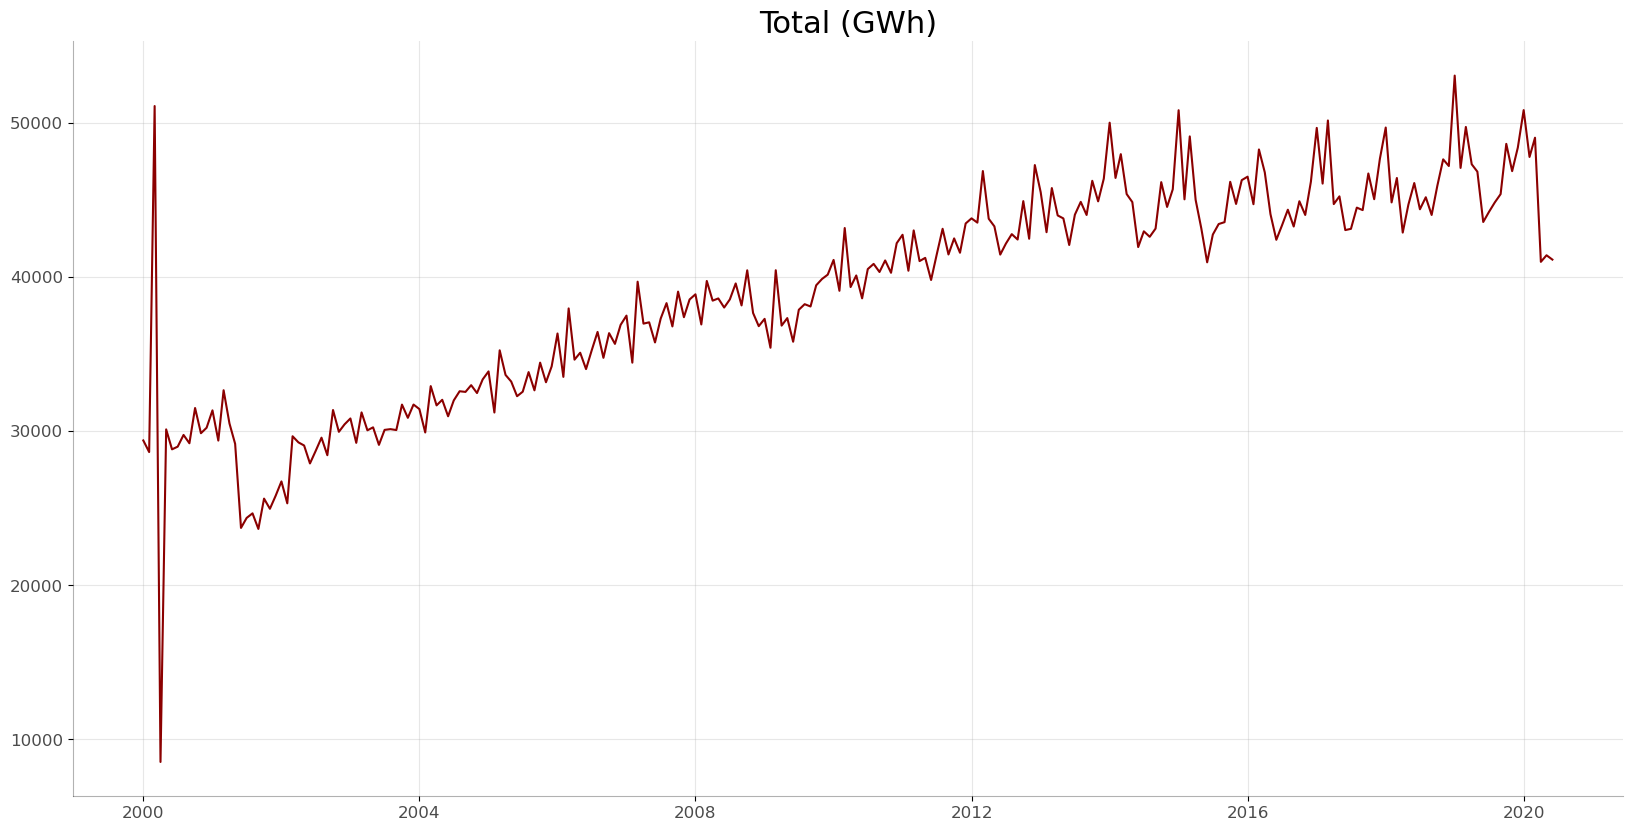

In [20]:
# Criação do objeto referente à Classe "Gráficos" da Energia Total (soma e soma_perc ainda não foram definidos)
total_graficos = Graficos('Total', dados, soma=None, soma_perc=None)

# Gráfico de linhas para os dados Totais de Energia
total_graficos.lineplot()

Analisando o gráfico de linhas, é notável um crescimento temporal e a presença de sazonalidade pela presença de pequenas oscilações periódicas. Entretanto, a oscilação em seus primeiros dados é muito discrepante em comparação com os outros dados. Agora, será analisado o boxplot desse conjunto de dados.

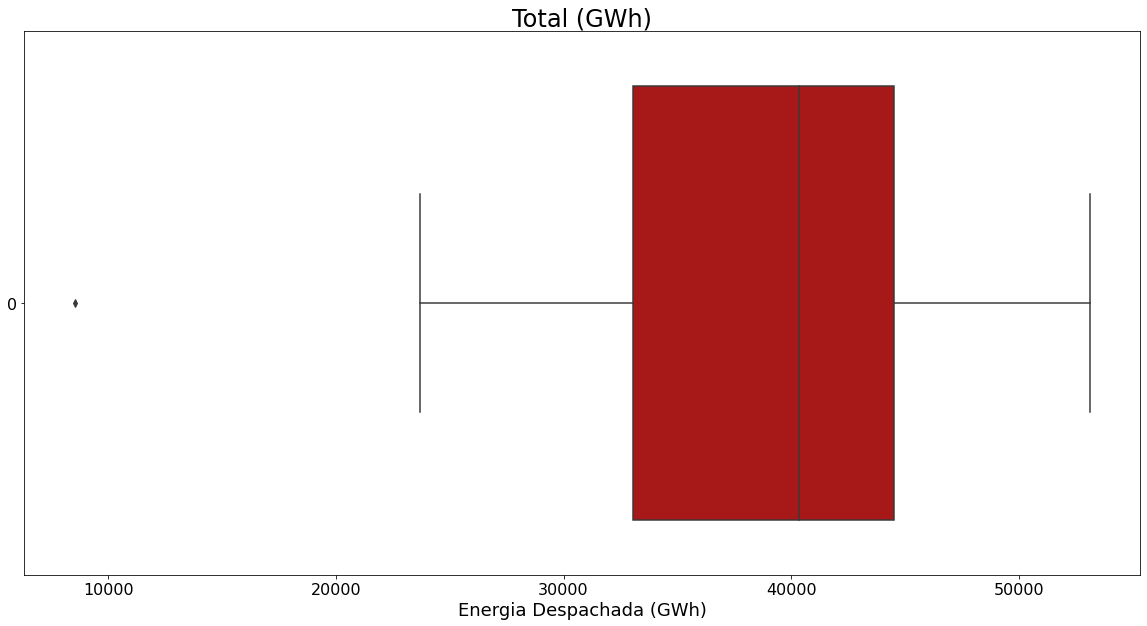

In [21]:
# Boxplot para os dados Totais de Energia
total_graficos.boxplot()

Através do boxplot é perceptível a presença de um outlier no boxplot. Portanto, é interessante fazer uma análise para identificar o período exato em que ocorre esse valor inesperado e plotar esses dados. Como a grande discrepância ocorre no começo do conjunto de dados, serão analisados os 10 primeiros dados.

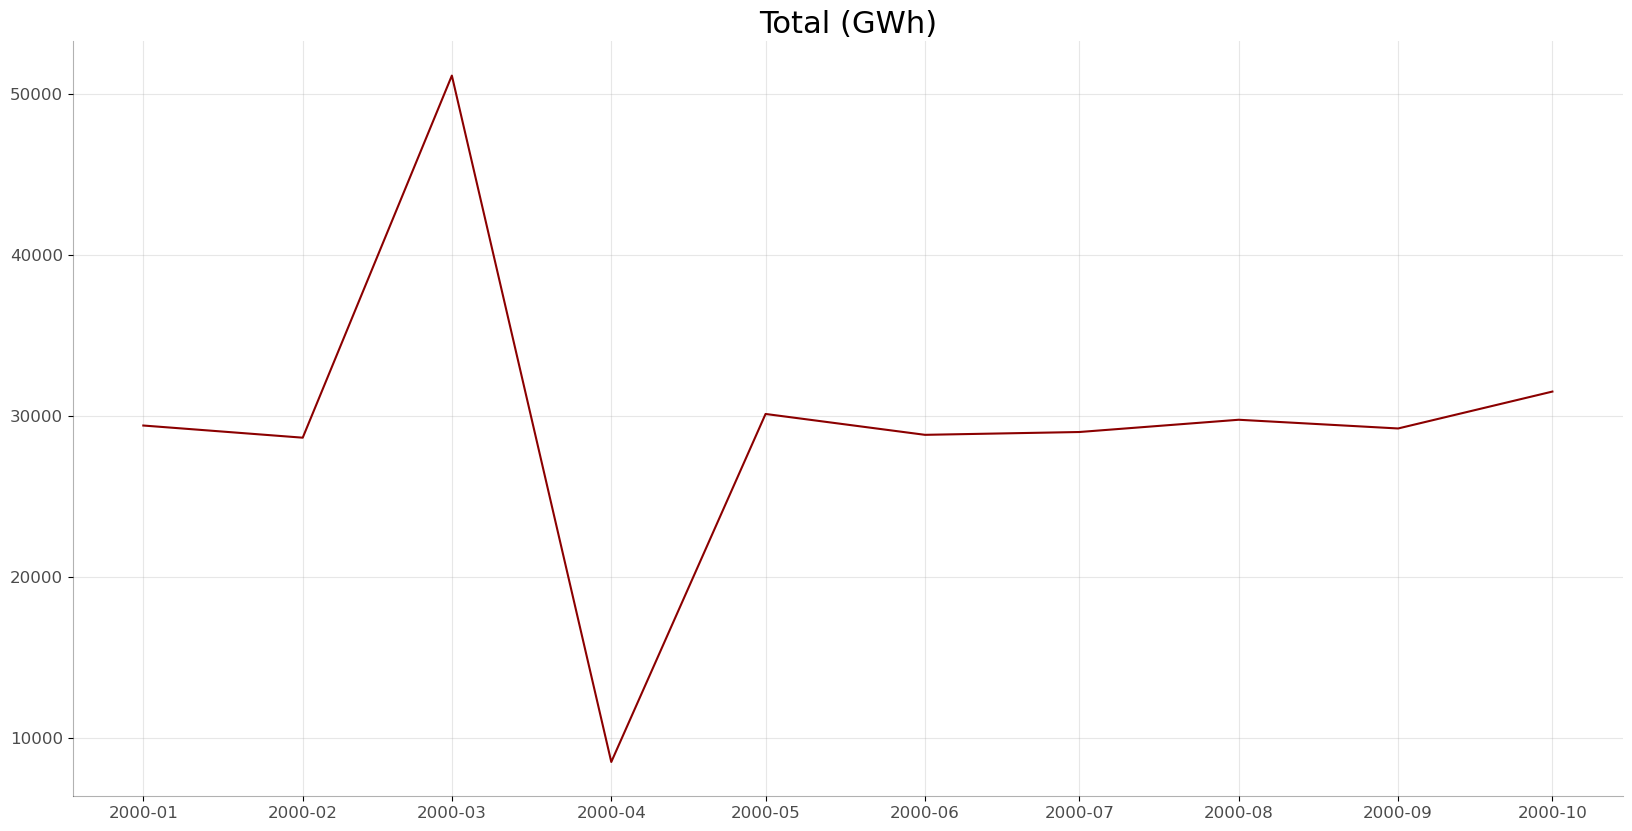

In [22]:
# Criação do objeto referente à Classe "Gráficos" da Energia Total (soma e soma_perc ainda foram definidos)
total_graficos = Graficos('Total', dados[:10], soma=None, soma_perc=None)

# Gráfico de linhas para os 10 primeiros dados
total_graficos.lineplot()

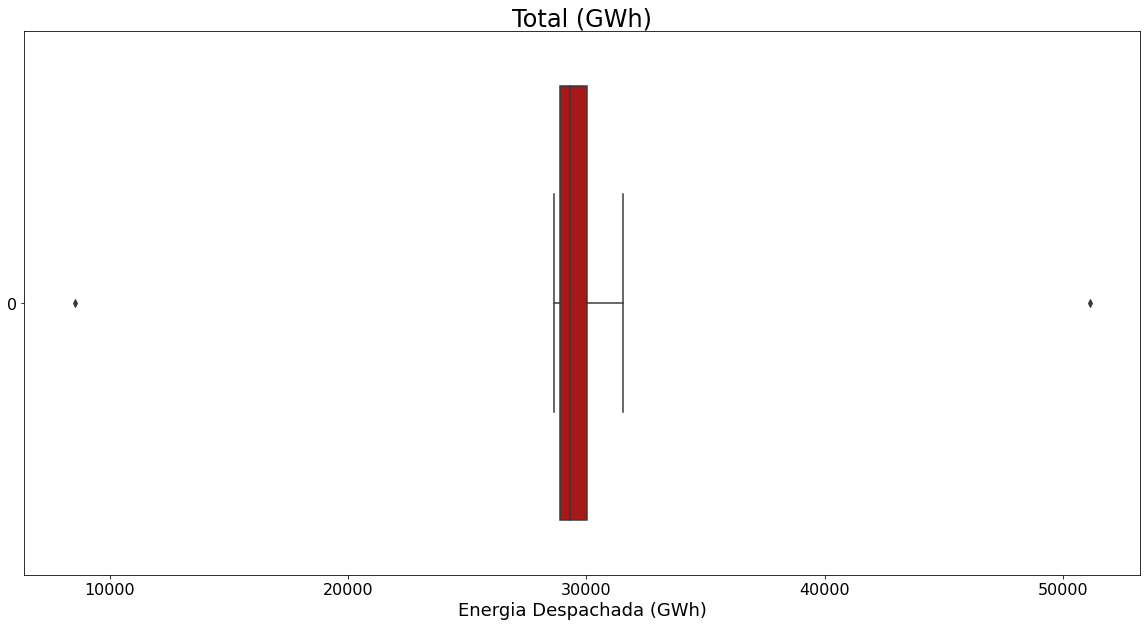

In [23]:
# Boxplot para os 10 primeiros dados
total_graficos.boxplot()

In [24]:
# Criação do objeto referente à Classe "Gráficos" da Energia Total (soma e soma_perc ainda foram definidos)
total_stats = Stats('Total', dados[:10])
# Obtenção dos valores outliers
total_stats.get_outliers()

(                Total
 date                 
 2000-04-01  8539.4778,
                    Total
 date                    
 2000-03-01  51126.435535)

Os gráficos acima mostram com maior detalhamento a grande variação nos dados de Energia Despachada Total nesses meses com um retorno à tendência de fev/2000 a partir de mai/2000, além da presença de dois dados muito discrepantes (mar/2000 e abr/2000). Segue abaixo uma amostra mais detalhada dos dados, avaliando os dados de Energia Despachada por Fonte de Energia.

In [25]:
# Visualização em DataFrame dos primeiros 10 dados 
dados.head(10)

nomFonteGeracao,Carvao,Gas_Natural,Nuclear,Oleo,Hidreletricas_exceto_Itaipu,Itaipu,Biomassas,Eolicas,Solar_Fotovoltaica,Fora_do_SIN,Residuos_Industriais,Renovavel,Nao_Renovavel,Hidreletricas,Renovaveis_sem_Hidro,Total_sem_Hidro,Total,month,year
date,,,,,,,,,,,,,,,,,,,
2000-01-01,772.954908,512.536500,418.609402,112.026593,21074.749841,6523.780292,0.0000,0.0,0.0,0.000,0.0,27598.530133,1816.127404,27598.530133,0.0000,1816.127404,29414.657538,1,2000
2000-02-01,726.482505,580.842549,400.617872,69.214905,20519.823366,6362.831799,0.0000,0.0,0.0,0.000,0.0,26882.655166,1777.157832,26882.655166,0.0000,1777.157832,28659.812997,2,2000
2000-03-01,685.798458,513.065176,400.187101,78.197350,21184.922627,7593.289824,0.0000,0.0,0.0,20670.975,0.0,28778.212451,1677.248084,28778.212451,0.0000,22348.223084,51126.435535,3,2000
2000-04-01,0.000000,675.601700,0.000000,337.403200,7128.300200,39.287100,358.8856,0.0,0.0,0.000,0.0,7526.472900,1013.004900,7167.587300,358.8856,1371.890500,8539.477800,4,2000
2000-05-01,725.874700,503.225500,0.000000,101.455500,21986.323500,6814.969400,0.0000,0.0,0.0,0.000,0.0,28801.292900,1330.555700,28801.292900,0.0000,1330.555700,30131.848600,5,2000
2000-06-01,725.001500,574.331600,0.011100,105.998400,20503.398688,6928.030200,0.0000,0.0,0.0,0.000,0.0,27431.428888,1405.342600,27431.428888,0.0000,1405.342600,28836.771488,6,2000
2000-07-01,607.471400,540.092500,67.880700,130.207000,20243.011430,7423.097700,0.0000,0.0,0.0,0.000,0.0,27666.109130,1345.651600,27666.109130,0.0000,1345.651600,29011.760730,7,2000
2000-08-01,627.496300,547.118200,672.390800,127.627800,20366.155900,7431.322900,0.0000,0.0,0.0,0.000,0.0,27797.478800,1974.633100,27797.478800,0.0000,1974.633100,29772.111900,8,2000
2000-09-01,397.343100,500.284800,781.171600,80.348230,19379.092090,8093.236840,0.0000,0.0,0.0,0.000,0.0,27472.328930,1759.147730,27472.328930,0.0000,1759.147730,29231.476660,9,2000


Percebe-se a inserção de valor de Energia na variável "Fora_do_SIN" em abril/2000 de forma inadequada, gerando um valor anormalmente alto para o mês de março e valores muito baixos para algumas variáveis no mês de abril, com o mês de maio possuindo valores mais coerentes para algumas variáveis. 

In [26]:
# Visualização em DataFrame dos dados da variável 'Fora_do_SIN' com valores maiores que zero
pd.DataFrame(dados.query('Fora_do_SIN > 0').Fora_do_SIN)

,Fora_do_SIN
date,
2000-03-01,20670.975000
2006-01-01,827.525252
2006-02-01,762.634875
2006-03-01,893.805701
2006-04-01,813.811430
...,...
2019-02-01,220.000000
2019-03-01,258.000000
2019-04-01,250.000000


O erro deduzido acima fica evidente ao notar que os valores de "Fora_do_SIN" só voltam a ser computados em janeiro de 2006.

In [27]:
# Seleção dos dados entre março e agosto de 2000
dados[2:8]

nomFonteGeracao,Carvao,Gas_Natural,Nuclear,Oleo,Hidreletricas_exceto_Itaipu,Itaipu,Biomassas,Eolicas,Solar_Fotovoltaica,Fora_do_SIN,Residuos_Industriais,Renovavel,Nao_Renovavel,Hidreletricas,Renovaveis_sem_Hidro,Total_sem_Hidro,Total,month,year
date,,,,,,,,,,,,,,,,,,,
2000-03-01,685.798458,513.065176,400.187101,78.19735,21184.922627,7593.289824,0.0000,0.0,0.0,20670.975,0.0,28778.212451,1677.248084,28778.212451,0.0000,22348.223084,51126.435535,3,2000
2000-04-01,0.000000,675.601700,0.000000,337.40320,7128.300200,39.287100,358.8856,0.0,0.0,0.000,0.0,7526.472900,1013.004900,7167.587300,358.8856,1371.890500,8539.477800,4,2000
2000-05-01,725.874700,503.225500,0.000000,101.45550,21986.323500,6814.969400,0.0000,0.0,0.0,0.000,0.0,28801.292900,1330.555700,28801.292900,0.0000,1330.555700,30131.848600,5,2000
2000-06-01,725.001500,574.331600,0.011100,105.99840,20503.398688,6928.030200,0.0000,0.0,0.0,0.000,0.0,27431.428888,1405.342600,27431.428888,0.0000,1405.342600,28836.771488,6,2000
2000-07-01,607.471400,540.092500,67.880700,130.20700,20243.011430,7423.097700,0.0000,0.0,0.0,0.000,0.0,27666.109130,1345.651600,27666.109130,0.0000,1345.651600,29011.760730,7,2000
2000-08-01,627.496300,547.118200,672.390800,127.62780,20366.155900,7431.322900,0.0000,0.0,0.0,0.000,0.0,27797.478800,1974.633100,27797.478800,0.0000,1974.633100,29772.111900,8,2000


Além disso, uma análise um pouco mais aprofundada sobre os dados desse período mostra que a Fonte Nuclear não tem valores computados em abril e maio, só possuindo valores semelhantes aos anteriores no mês de agosto de 2000. Sendo essa a última variável a ter uma grande discrepância nos dados não explicada, é conveniente considerar os dados a partir do mês de agosto de 2000, criando-se uma nova variável para computar os dados.

In [28]:
# Criação da nova variável "dados_limpos"
dados_limpos = dados[7:]
dados_limpos

nomFonteGeracao,Carvao,Gas_Natural,Nuclear,Oleo,Hidreletricas_exceto_Itaipu,Itaipu,Biomassas,Eolicas,Solar_Fotovoltaica,Fora_do_SIN,Residuos_Industriais,Renovavel,Nao_Renovavel,Hidreletricas,Renovaveis_sem_Hidro,Total_sem_Hidro,Total,month,year
date,,,,,,,,,,,,,,,,,,,
2000-08-01,627.496300,547.118200,672.390800,127.627800,20366.15590,7431.322900,0.00000,0.00000,0.00000,0.0,0.00000,27797.478800,1974.633100,27797.478800,0.00000,1974.633100,29772.111900,8,2000
2000-09-01,397.343100,500.284800,781.171600,80.348230,19379.09209,8093.236840,0.00000,0.00000,0.00000,0.0,0.00000,27472.328930,1759.147730,27472.328930,0.00000,1759.147730,29231.476660,9,2000
2000-10-01,337.300572,551.155034,537.460912,70.415993,22529.27722,7495.719297,0.00000,0.00000,0.00000,0.0,0.00000,30024.996517,1496.332511,30024.996517,0.00000,1496.332511,31521.329028,10,2000
2000-11-01,489.986000,548.470000,1121.170800,100.395000,20175.47379,7448.224300,0.00000,0.00000,0.00000,0.0,0.00000,27623.698090,2260.021800,27623.698090,0.00000,2260.021800,29883.719890,11,2000
2000-12-01,640.149800,673.443400,1221.245700,94.221500,19822.51809,7787.367770,0.00000,0.00000,0.00000,0.0,0.00000,27609.885860,2629.060400,27609.885860,0.00000,2629.060400,30238.946260,12,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,1000.854960,3349.402560,948.641040,46.534560,32612.88960,5646.801120,309.88008,2710.30752,357.36816,0.0,838.10232,41637.246480,5345.433120,38259.690720,3377.55576,9561.091200,47820.781920,2,2020
2020-03-01,643.321920,2616.893520,1282.120320,84.220800,35229.70944,5294.795040,451.83864,2215.23768,419.48208,0.0,832.03008,43611.062880,4626.556560,40524.504480,3086.55840,8545.145040,49069.649520,3,2020
2020-04-01,202.917600,2068.552800,1358.755200,124.992000,28373.40000,3886.149600,759.34080,3039.06240,438.44400,0.0,759.37680,36496.396800,3755.217600,32259.549600,4236.84720,8751.441600,41010.991200,4,2020


Isso demonstra a dificuldade de se lidar com dados reais. Muitas vezes eles podem ser computados de forma indevida, que é evidente quando a discrepância é muito fácil de ser notada. Entretanto, muitos erros podem ser mais sutis e passar desapercebidos. Ademais, mudanças em políticas governamentais, a inserção de uma nova fonte na matriz energética ou alguma dificuldade no fornecimento de insumos pode gerar desvios nos padrões observados anteriormente. Retomando a frase inicial, lidar com dados reais é complicado e precisa-se muita capacidade analítica, conhecimento do assunto e minunciosidade. 

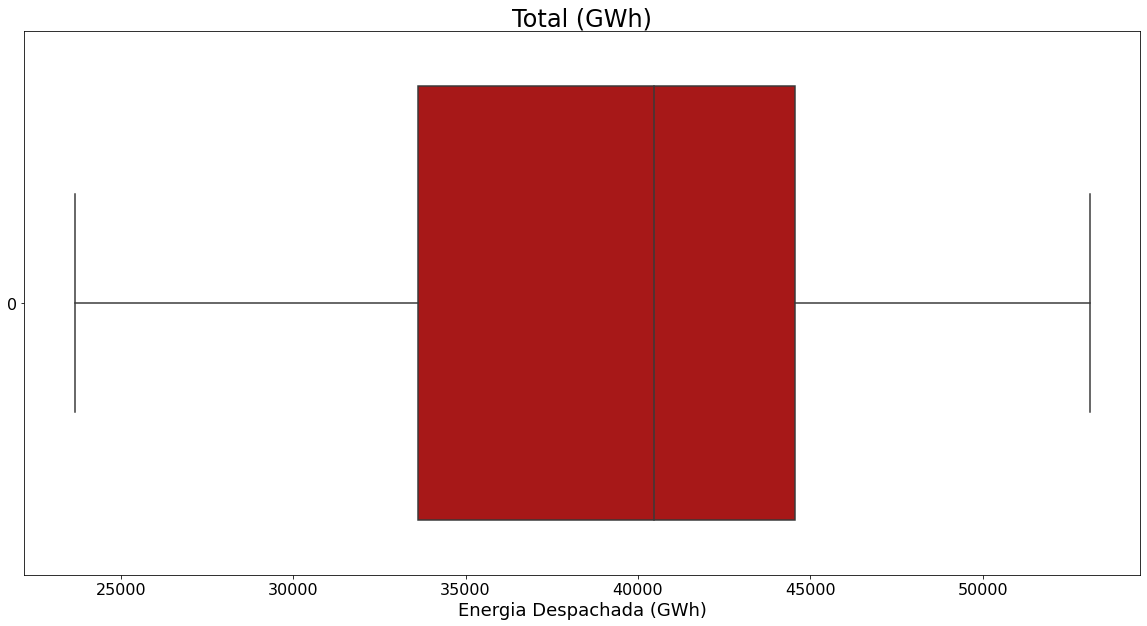

In [29]:
# Atualização do objeto referente à Classe "Gráficos" da Energia Total (soma e soma_perc ainda foram definidos)
total_graficos = Graficos('Total', dados_limpos, soma=None, soma_perc=None)

# Plot do boxplot dos dados totais após limpeza
total_graficos.boxplot()

Agora os dados de Energia Total aparentam possuir um comportamento mais adequado, o que incentiva o aprofundamento da análise e a inferência de tendências dos fenômenos observados. Dessa forma, esses serão os dados utilizados para as análises do restante do trabalho.

### 3.3. Criação de DataFrames Auxiliares

Uma análise importante pode ser realizada através do agrupamento das variáveis através do ano. Dessa forma, poderá se comparar a soma dos dados consolidados para cada ano individualmente. Logo, dois DataFrames Auxiliares serão criados para evaluar a soma dos valores de cada variável entre 2001 e 2019 (visto que esses são os valores totais disponíveis) e para evaluar a variação percentual anual de energia.

In [30]:
# Criação do DataFrame com os valores somados para os respectivos anos
soma = dados_limpos.drop(columns='month')
soma = soma.groupby('year').sum()[1:20]
soma = soma.reset_index()
day = pd.Series(31 for x in range(len(soma)))
soma['day'] = day.values
month = pd.Series(12 for x in range(len(soma)))
soma['month'] = month.values

soma['date'] = pd.to_datetime(soma[['year', 'month', 'day']])

soma = soma.set_index('date', drop=True)
soma = soma.drop(columns = ['day', 'month', 'year'])

# Criação do DataFrame com as variações percentuais para os respectivos anos
soma_perc = soma.pct_change()*100

# Preencher os valores nulos com zero
soma_perc=soma_perc.fillna(0)

# Renomeação das colunas no DataFrame com os dados percentuais
for i in range(len(soma.columns)):
    soma_perc = soma_perc.rename(columns = {soma_perc.columns[i]: f'{soma_perc.columns[i]}_perc'})

In [31]:
# Informações referentes ao DataFrame Auxiliar "soma"
soma.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2001-12-31 to 2019-12-31
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Carvao                       19 non-null     float64
 1   Gas_Natural                  19 non-null     float64
 2   Nuclear                      19 non-null     float64
 3   Oleo                         19 non-null     float64
 4   Hidreletricas_exceto_Itaipu  19 non-null     float64
 5   Itaipu                       19 non-null     float64
 6   Biomassas                    19 non-null     float64
 7   Eolicas                      19 non-null     float64
 8   Solar_Fotovoltaica           19 non-null     float64
 9   Fora_do_SIN                  19 non-null     float64
 10  Residuos_Industriais         19 non-null     float64
 11  Renovavel                    19 non-null     float64
 12  Nao_Renovavel                19 non-null     float64
 13  Hi

In [32]:
# Informações referentes ao DataFrame Auxiliar "soma_perc"
soma_perc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2001-12-31 to 2019-12-31
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Carvao_perc                       19 non-null     float64
 1   Gas_Natural_perc                  19 non-null     float64
 2   Nuclear_perc                      19 non-null     float64
 3   Oleo_perc                         19 non-null     float64
 4   Hidreletricas_exceto_Itaipu_perc  19 non-null     float64
 5   Itaipu_perc                       19 non-null     float64
 6   Biomassas_perc                    19 non-null     float64
 7   Eolicas_perc                      19 non-null     float64
 8   Solar_Fotovoltaica_perc           19 non-null     float64
 9   Fora_do_SIN_perc                  19 non-null     float64
 10  Residuos_Industriais_perc         19 non-null     float64
 11  Renovavel_perc                    19 non-null     flo

In [33]:
# Informações referentes ao DataFrame Auxiliar
soma_perc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2001-12-31 to 2019-12-31
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Carvao_perc                       19 non-null     float64
 1   Gas_Natural_perc                  19 non-null     float64
 2   Nuclear_perc                      19 non-null     float64
 3   Oleo_perc                         19 non-null     float64
 4   Hidreletricas_exceto_Itaipu_perc  19 non-null     float64
 5   Itaipu_perc                       19 non-null     float64
 6   Biomassas_perc                    19 non-null     float64
 7   Eolicas_perc                      19 non-null     float64
 8   Solar_Fotovoltaica_perc           19 non-null     float64
 9   Fora_do_SIN_perc                  19 non-null     float64
 10  Residuos_Industriais_perc         19 non-null     float64
 11  Renovavel_perc                    19 non-null     flo

Verificamos que os dois DataFrames Auxiliares possuem 19 entradas dispostas em 17 colunas, onde o index é do tipo "DateTime" enquanto as outras variáveis são do tipo "float64" (ponto flutuante).

## 4. ANÁLISE EXPLORATÓRIA 

### 4.1. Visão Geral dos Dados

Após a realização de todas as alterações no dataset, essa é a sua configuração atual:

| Variável | Tipo | Descrição| 
|:------:|:------:|:------:|
|   date  | datetime64[ns] (index) | Data referente ao processamento de carga|
|   Carvao  | float64 | Energia despachada pela Fonte Carvão em GWh|
|   Gas_Natural  | float64 | Energia despachada pela Fonte Gás Natural em GWh|
|   Nuclear  | float64 | Energia despachada pela Fonte Nuclear em GWh|
|   Oleo  | float64 | Energia despachada por Derivados de Petróleo (Óleo Diesel/Combustível) em GWh|
|   Hidreletricas_exceto_Itaipu  | float64 | Energia despachada pela Fonte Hidrelétrica (exceto Itaipu) em GWh|
|   Itaipu  | float64 | Energia despachada pela Fonte Itaipu em GWh|
|   Biomassas  | float64 | Energia despachada pela Fonte Biomassas em GWh|
|   Eolicas  | float64 | Energia despachada pela Fonte Eólicas em GWh|
|   Solar_Fotovoltaica  | float64 | Energia despachada pela Fonte Solar Fotovoltaica em GWh|
|   Fora_do_SIN  | float64 | Energia despachada Fora do SIN em GWh|
|   Residuos_Industriais  | float64 | Energia despachada pela Fonte Resíduos Industriais em GWh|
|   Renovavel  | float64 | Energia despachada pelo agrupamento de Fontes Renováveis em GWh|
|   Nao_Renovavel  | float64 | Energia despachada pelo agrupamento de Fontes Não Renováveis em GWh|
|   Hidreletricas  | float64 | Energia despachada pelo agrupamento de Fontes Hidrelétricas em GWh|
|   Renovaveis_sem_Hidro  | float64 | Energia despachada pelo agrupamento de Fontes Renováveis (exceto as Hidrelétricas) em GWh|
|   Total_sem_Hidro  | float64 | Energia Total despachada (exceto a Fonte Hidrelétrica) em GWh|
|   Total  | float64 |Energia Total despachada em GWh|
|   month  | int64   | Mês referente ao processamento de carga|
|   year  | int64   | Ano referente ao processamento de carga|

In [34]:
# Informações sobre os dados do DataFrame
dados_limpos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 239 entries, 2000-08-01 to 2020-06-01
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Carvao                       239 non-null    float64
 1   Gas_Natural                  239 non-null    float64
 2   Nuclear                      239 non-null    float64
 3   Oleo                         239 non-null    float64
 4   Hidreletricas_exceto_Itaipu  239 non-null    float64
 5   Itaipu                       239 non-null    float64
 6   Biomassas                    239 non-null    float64
 7   Eolicas                      239 non-null    float64
 8   Solar_Fotovoltaica           239 non-null    float64
 9   Fora_do_SIN                  239 non-null    float64
 10  Residuos_Industriais         239 non-null    float64
 11  Renovavel                    239 non-null    float64
 12  Nao_Renovavel                239 non-null    float64
 13  H

Podemos verificar que o DataFrame possui agora 239 entradas dispostas em 19 colunas, sem a presença de valores nulos. Além disso, confirmamos que o conjuntos de dados é referente ao período de agosto/2000 até junho/2020.

### 4.2. Análise da correlação entre as Fontes de Energia

O objetivo dessa etapa é avaliar as correlações existentes entre cada Fonte de Energia a partir do plot de dois gráficos. O primeiro, chamado "pair grid", é composto de 3 tipos de gráficos: 

- Diagonal: Histograma da variável presente na diagonal (análise da variável individual);
- Inferior à Diagonal: Estimativa de densidade Kernel entre as 2 variáveis ;
- Superior à Diagonal: Dispersão dos dados entre as 2 variáveis.

O segundo é um mapa de calor (heatmap) que irá demonstrar a correlação entre as variáveis.

In [35]:
# Criação do objeto referente às variáveis utilizadas para análises de correlação
selecao = dados_limpos[dados_limpos.columns[0:11]]
corr = Correlacao(selecao)

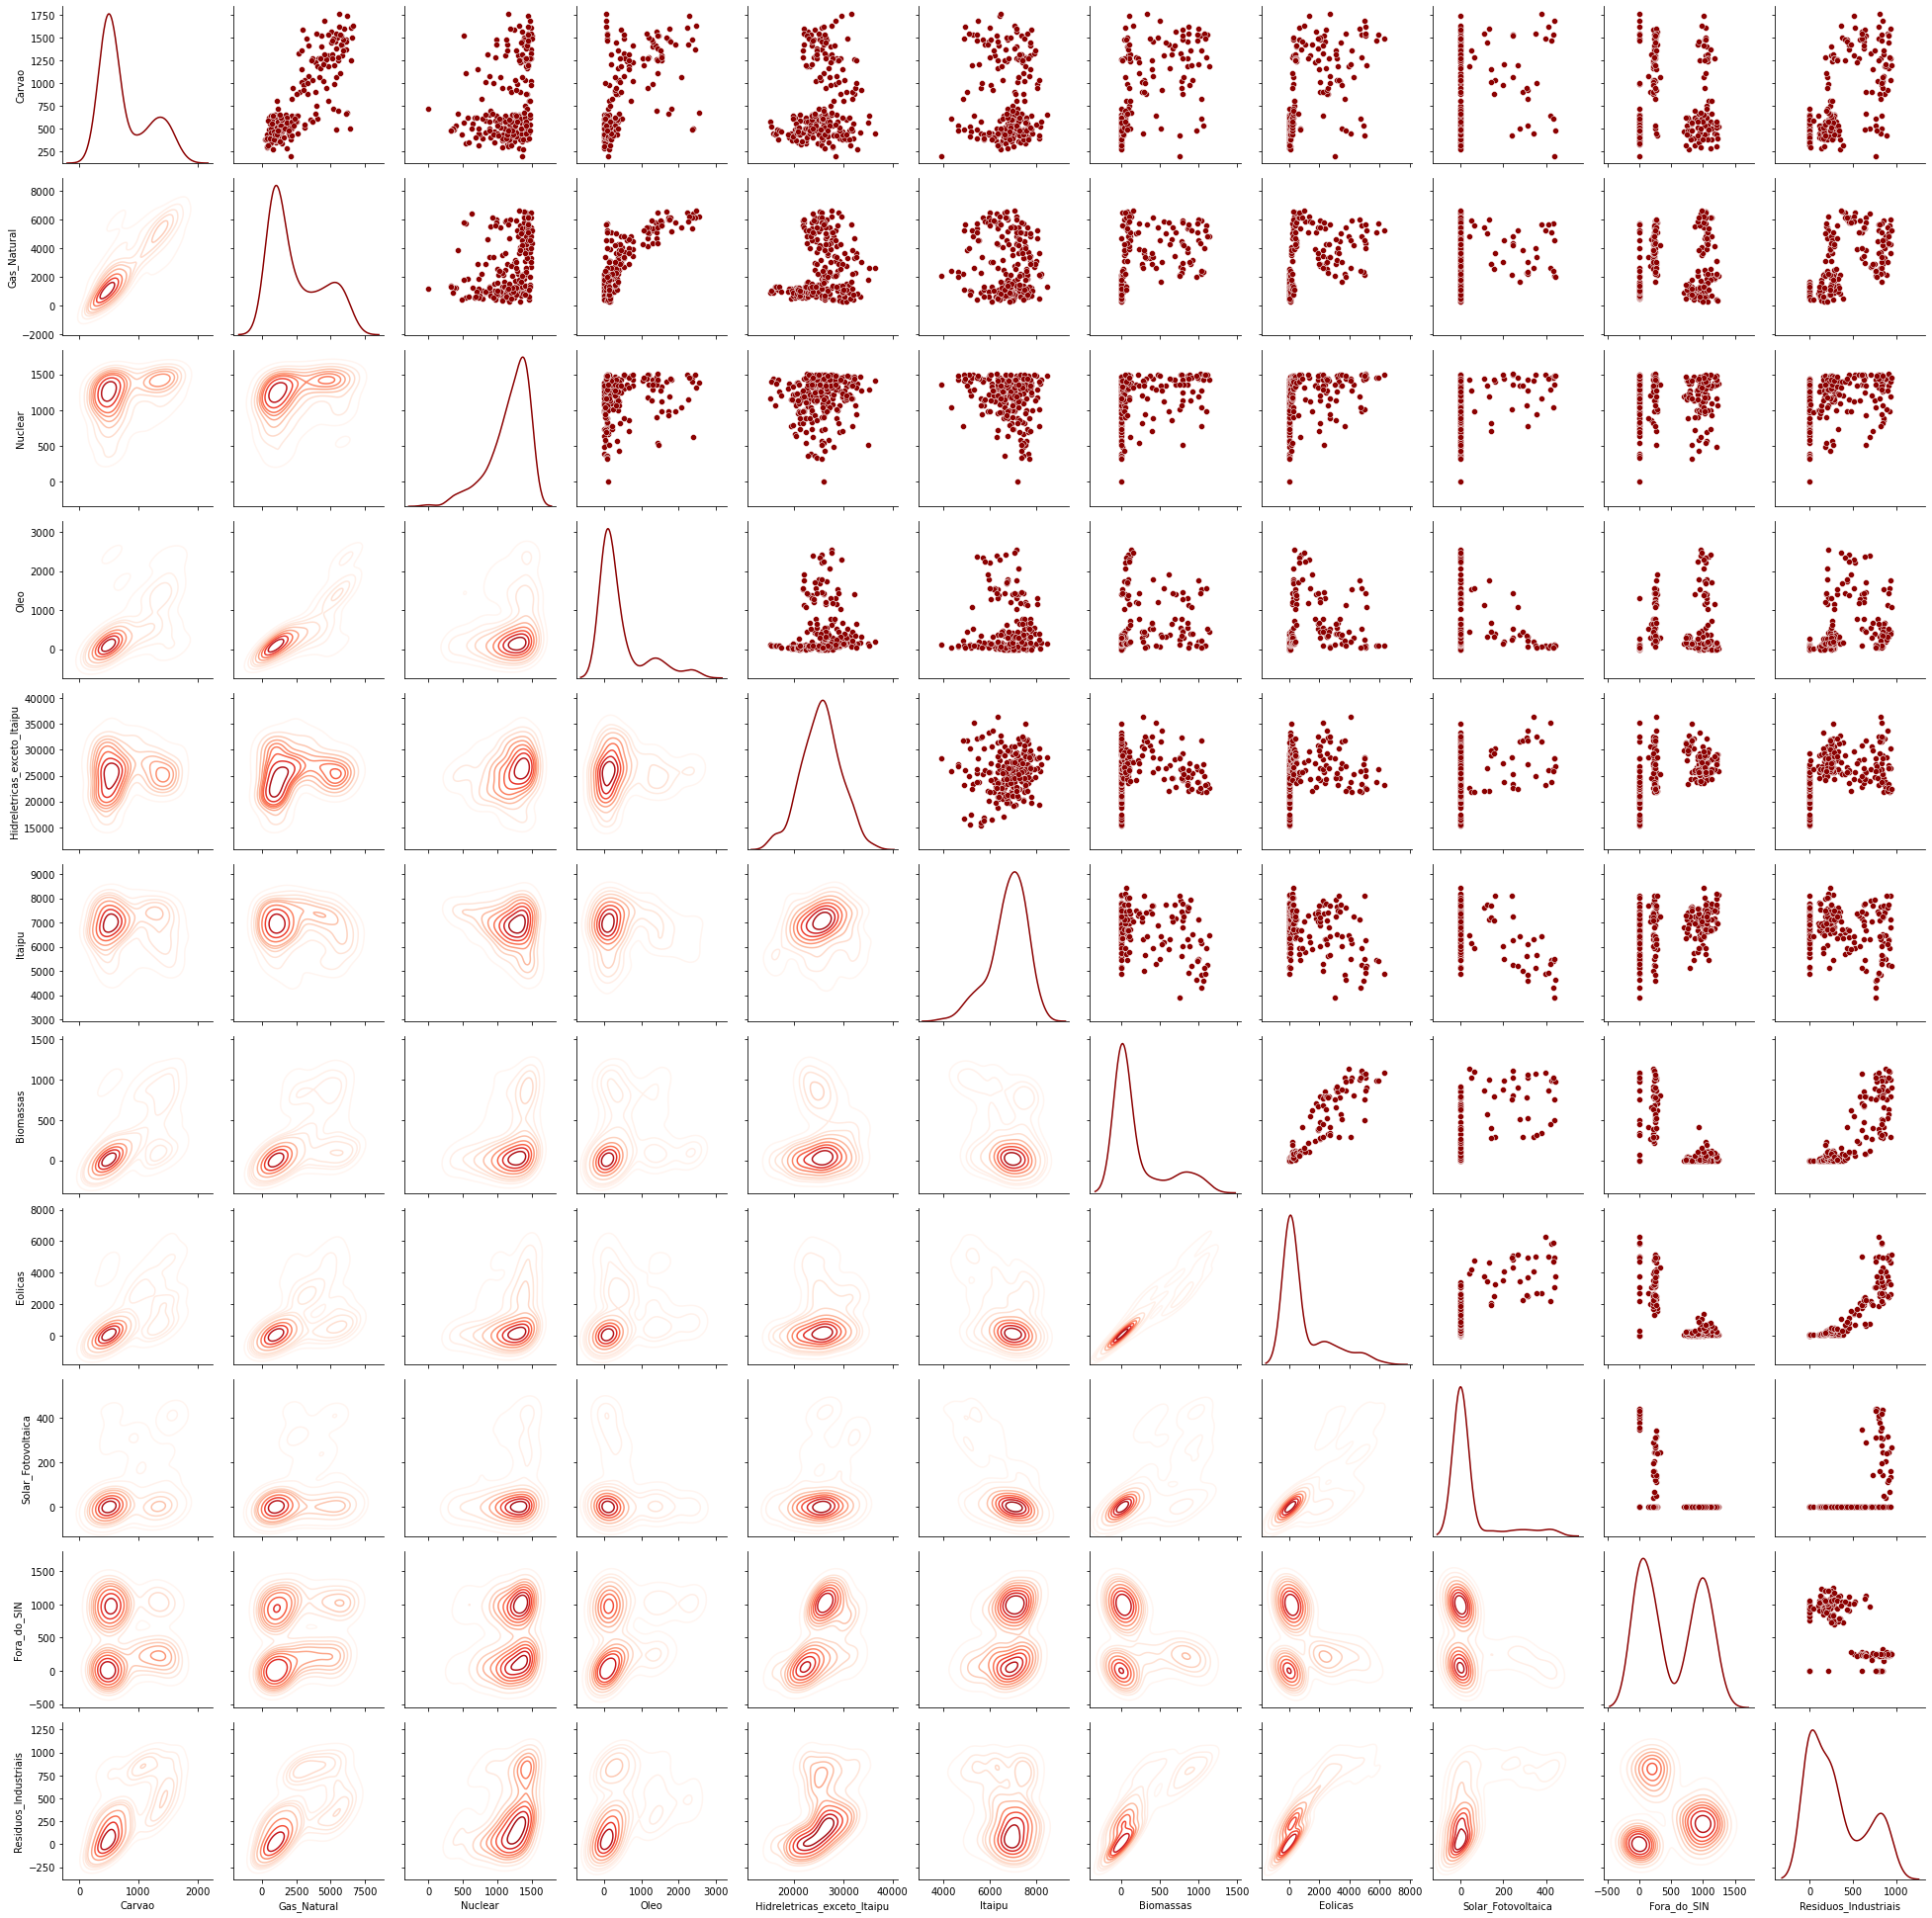

In [36]:
# Pair Grid para as Fontes de Energia
corr.pairgrid()

Os Histogramas de cada variável possuem desvios em relação à normalidade, com exceção da variável "Hidrelétricas (exceto Itaipu)", que possui uma distribuição bem simétrica. Com exceção da Fonte Nuclear - que possui Assimetria Negativa - todas as outras variáveis possuem Assimetria Positiva. Através dos gráficos de dispersão, não se nota uma grande correlação entre a maioria das variáveis.

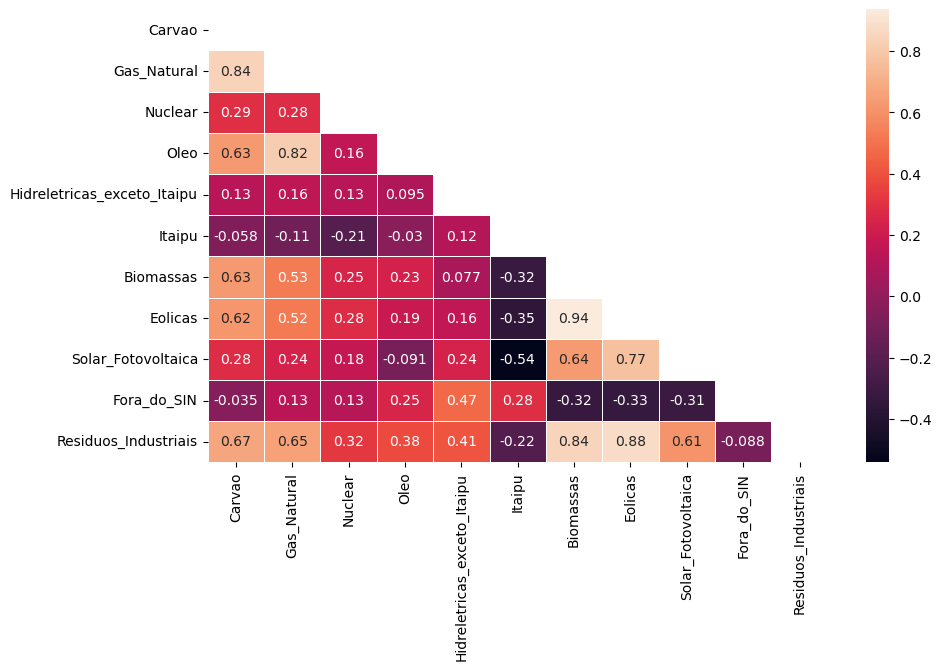

In [37]:
# Correlação entre as Fontes de Energia
corr.heatmap()

O mapa de calor acima mostra que grande parte das fontes não possuem fortes correlações entre si, de forma que apenas 5 variáveis possuem valores de correlação acima de 0.8, explicitadas abaixo:

In [38]:
# Seleção de valores com correlação acima de 0.8
corr.seleciona_corr(0.8, '>')

,Variável 1,Variável 2,Correlação
0,Biomassas,Eolicas,0.936269
1,Eolicas,Residuos_Industriais,0.877725
2,Biomassas,Residuos_Industriais,0.844093
3,Carvao,Gas_Natural,0.843714
4,Gas_Natural,Oleo,0.818324


Percebe-se uma forte correlação entre duas variáveis Não Renováveis ("Gás Natural" com "Carvão" e "Óleo Diesel/Combustível") e a maior correlação é vista entre "Biomassas" e "Eólicas", sendo a única superior à 0,936. Já "Resíduos Industriais", que obteve crescimento recente, correlaciona-se muito bem com Biomassas e Eólicas que tiveram mesma tendência. É possível inferir uma causalidade, visto que, pelas fontes possuírem naturezas semelhantes - Renovável ou Não Renovável - seus crescimentos ocorreram em momentos semelhantes através de políticas governamentais de expansão.

In [39]:
# Seleção de valores com correlação abaixo de -0.3
corr.seleciona_corr(-0.3, '<')

,Variável 1,Variável 2,Correlação
0,Solar_Fotovoltaica,Fora_do_SIN,-0.314258
1,Itaipu,Biomassas,-0.321577
2,Biomassas,Fora_do_SIN,-0.323824
3,Eolicas,Fora_do_SIN,-0.329168
4,Itaipu,Eolicas,-0.354621
5,Itaipu,Solar_Fotovoltaica,-0.541790


Já entre os valores com correlações negativas, foram selecionadas as variáveis abaixo de -0.3. Nota-se que "Itaipu" e "Fora do SIN" possuem correlações negativas em comparação com "Biomassas", "Eólicas" e "Solar Fotovoltaica". Como o comportamento de "Fora do SIN" é irregular, o foco ficará na correlação de "Itaipu" com fontes renováveis que tiveram crescimento na Matriz Elétrica recente ao passo que "Itaipu" teve queda na sua produção pela crise na sua Bacia Hidrográfica. Portanto, não dá para inferir causalidade entre as correlações negativas mais fortes vistas no conjunto de dados.

### 4.3. Exploração da Variável "Total"

Criação dos objetos do Agrupamento Total referentes às classes "Stats" e "Graficos", além da seleção das variáveis pertencentes ao agrupamento.

In [40]:
# Criação do objeto referente à Classe "Nulos" de "Total"
total_nulos = Nulos('Total', dados_limpos)

# Criação do objeto referente à Classe "Stats" de "Total"
total_stats = Stats('Total', dados_limpos)

# Criação do objeto referente à Classe "Graficos" de "Total"
total_graficos = Graficos('Total', dados_limpos, soma, soma_perc)

# Seleção das variáveis do agrupamento
total_selecao = dados_limpos[['Total', 'Hidreletricas', 'Nao_Renovavel', 'Renovaveis_sem_Hidro', 'Residuos_Industriais', 'Fora_do_SIN']]

In [41]:
total_nulos.nulos()

Series([], Name: Total, dtype: float64)

Não há valores nulos para essa variável, como esperado, visto que se trata da produção de Energia Total.

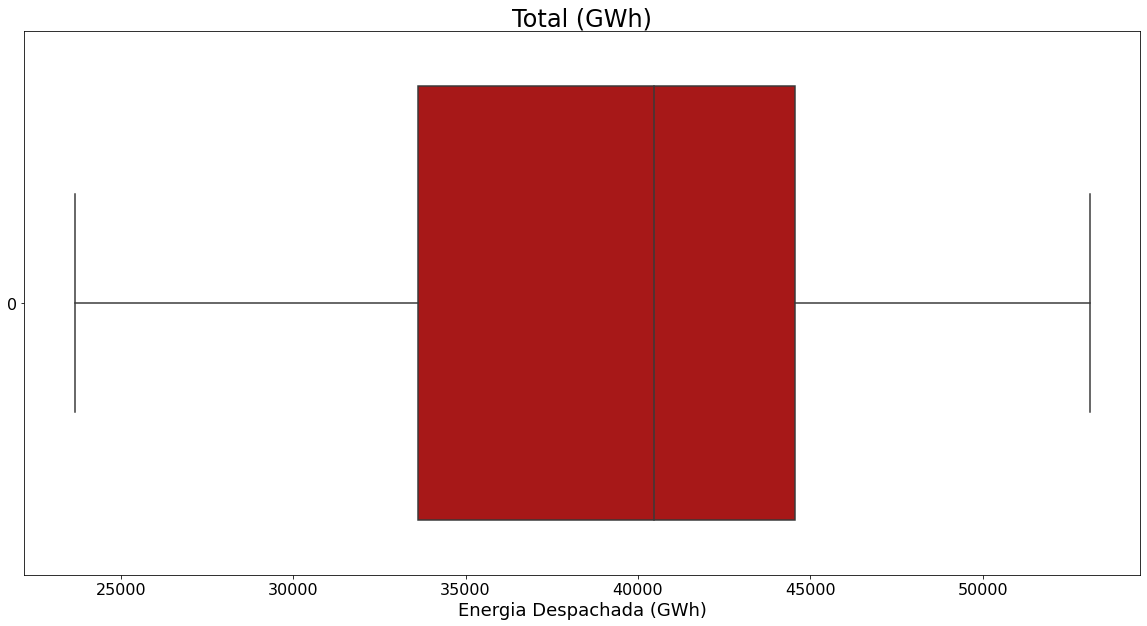

In [42]:
# Boxplot para a Energia Despachada Total
total_graficos.boxplot()

In [43]:
# Descrição estatística para a Energia Despachada Total
total_stats.descricao()

,Total
count,239.000000
mean,39245.896169
std,6595.563042
min,23669.928370
25%,33605.637581
50%,40461.274022
75%,44554.007504
max,53103.613862


O boxplot não apresenta outliers, com os dados se concentrando mais intensamente na faixa entre e a mediana e o terceiro quartil (40641,27 GWh e 44554,01 GWh). A média de Energia Total Despachada no conjunto de dados foi de 39245,90 GWh, com 23669,93 GWh como valor mínimo e 53103,61 GWh como valor máximo.

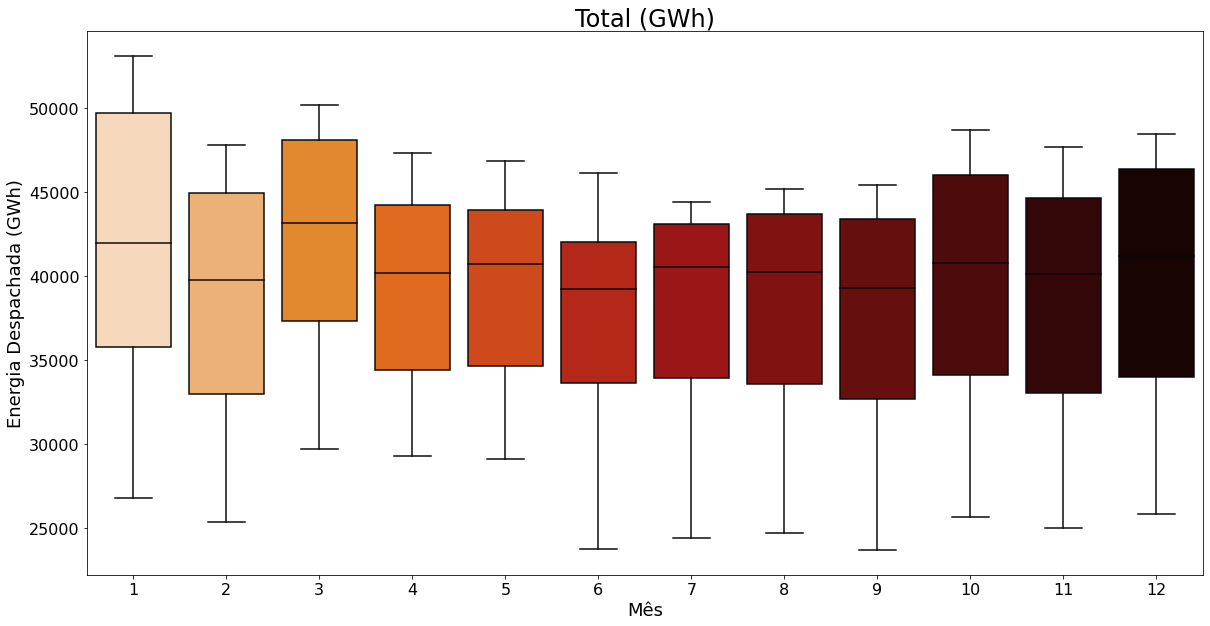

In [44]:
# Boxplot para a Energia Despachada Total para cada mÊs
total_graficos.boxplot_mensal()

Os boxplots referentes à cada mês demonstram a presença de sazonalidade no conjunto de dados, visto que há uma clara diferença no comportamento da variável em meses distintos. Percebe-se que janeiro e março concentram os maiores valores de energia despachada enquanto nota-se uma queda entre abril e setembro, com destaque para o mês de junho.

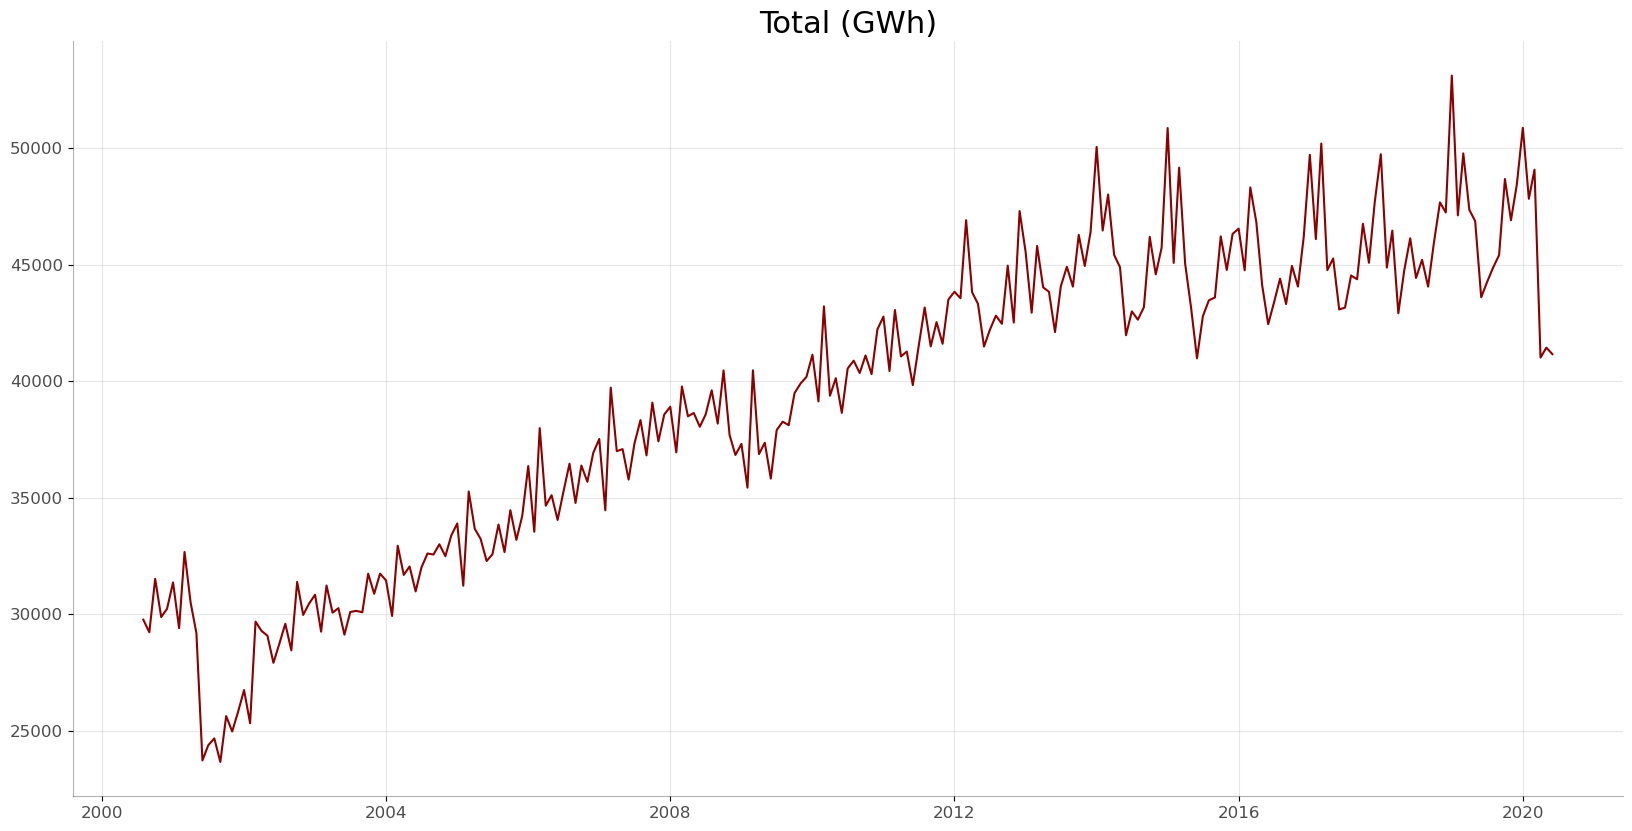

In [45]:
# Lineplot para Energia Despachada Total
total_graficos.lineplot()

Ao observar o gráfico de linhas, nota-se uma grande queda no começo de 2001. Desde então nota-se um crescimento gradual de Energia Total - excetuando-se o período entre 2008 e 2009 - onde é evidente a presença cada vez mais forte de fatores sazonais na Matriz Elétrica.

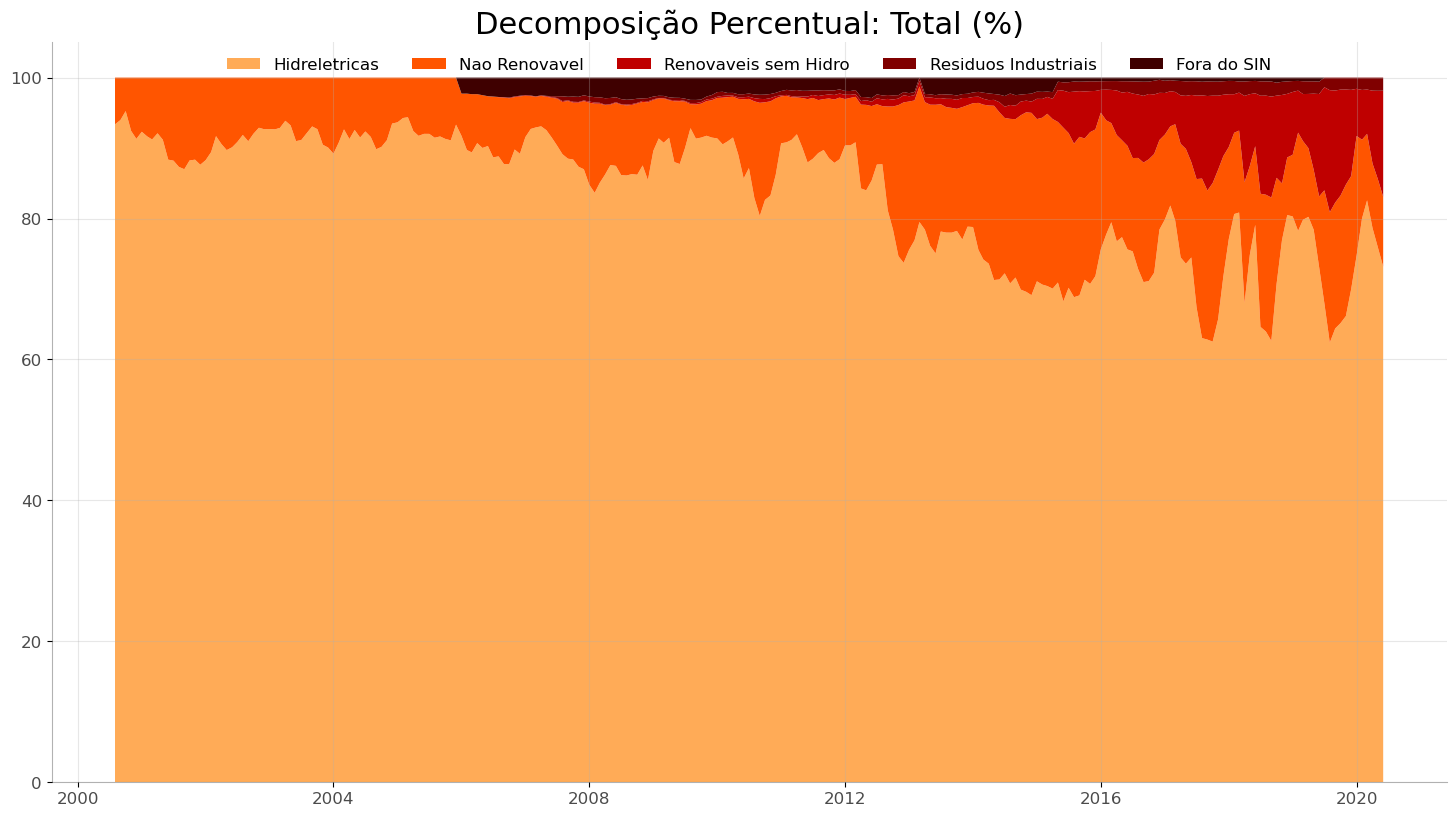

In [46]:
total_graficos.areaplot(total_selecao)

Nota-se que até 2012, a Energia Hidrelétrica predominava fortemente na Matriz Elétrica Brasileira, chegando a representar quase 90% da Energia Total em alguns momentos. A partir deste momento, percebe-se um forte aumento no uso de Fontes Não Renováveis até meados da década, onde percebe-se um aumento proporcional na utilização de Fontes Renováveis (exceto Hidrelétricas), chegando a representar quase 20% da Energia Despachada Total.

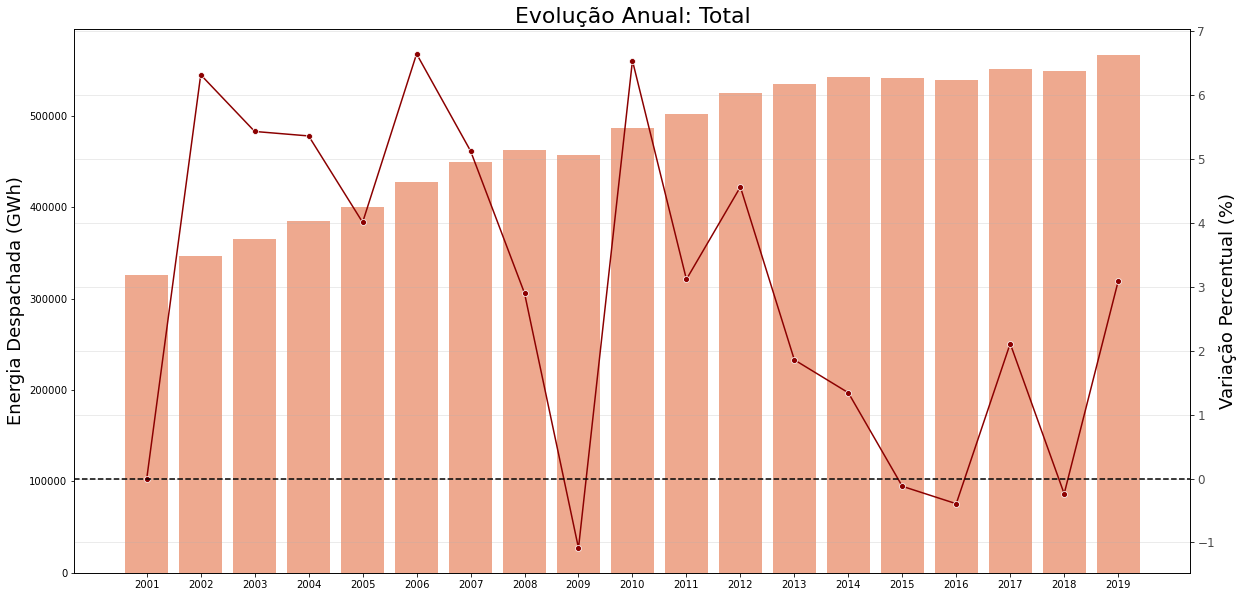

In [47]:
# Gráfico de barras da Energia Despachada Total em conjunto com um Gráfico de linhas indicando sua variação percentual anual 
total_graficos.mixedplot()

A Energia Despachada Total cresceu constantemente desde o começo da Série Histórica até 2014, com 2009 sendo a única exceção, influenciada pela queda econômica gerada pela Crise Mundial. Entretanto, em 2015 e 2016 houveram quedas como resultado de uma Crise Econômica Interna, procedida de um crescimento de mais de 2% em 2017 e de mais de 3% em 2019, excetuando-se 2018 que observou uma ligeira queda.

Um ponto relevante de discussão para a história da Matriz Elétrica Brasileira consiste em compreender o período de queda na produção observada entre 2001 e 2002. Ao observar o gráfico de área, percebe-se que nesse período a Matriz Elétrica era fortemente dominada pelas Hidrelétricas, que possuíam participação acima de 90%. Entretanto, sua participação caiu largamente nesse período, ocasionando uma forte queda na produção total de energia.

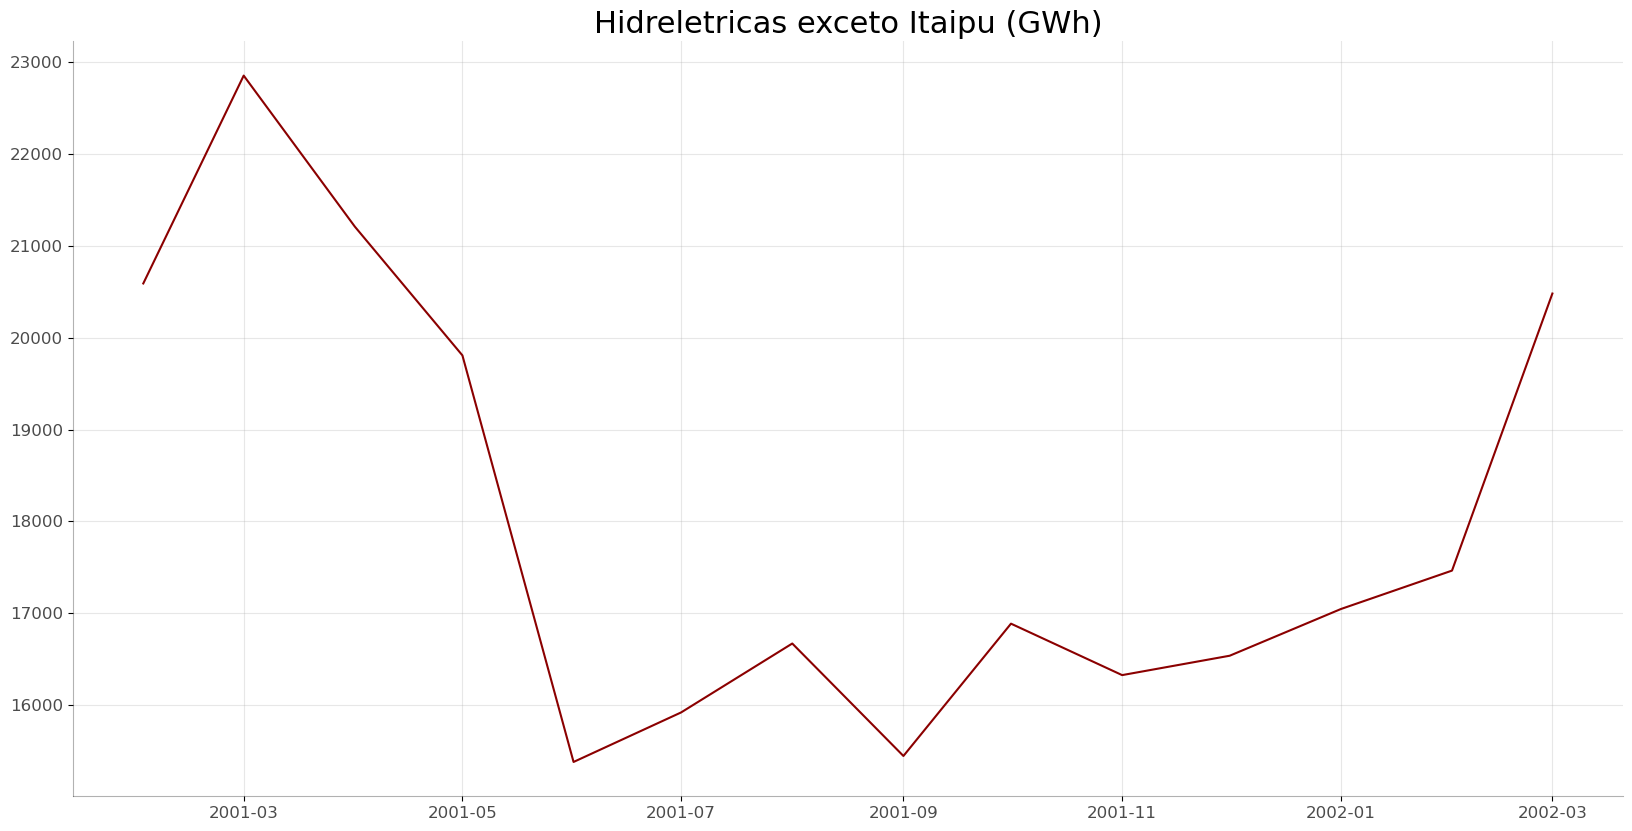

In [48]:
# Criação do objeto referente à Classe "Graficos" de "Hidrelétrica (exceto Itaipu)"
hidro_sem_ita_graficos = Graficos('Hidreletricas_exceto_Itaipu', dados_limpos.loc['02-2001':'03-2002'], soma, soma_perc)

# Lineplot para a Fonte Hidrelétrica (exceto Itaipu) entre fevereiro de 2001 e março de 2002
hidro_sem_ita_graficos.lineplot()

Nesse período houve um problema de fornecimento de energia hidrelétrica, ocasionando a "crise do Apagão". Para evitar um colapso do sistema energético, foi adotado um racionamento de energia para as Regiões Sudeste, Nordeste e Centro-Oeste, premiando pessoas que reduziam seus consumos e penalizando quem não o fizesse. O racionamento vigorou entre junho de 2001 e fevereiro de 2002, o que coincide com os dados mostrados no gráfico acima. 

Mais detalhes na matéria que pode ser acessada pelo [link](https://www.nexojornal.com.br/expresso/2021/05/31/Como-a-crise-atual-do-setor-el%C3%A9trico-se-compara-a-2001).

O principal motivo para a crise foi a forma como a Matriz Elétrica Brasileira falhou na sua expansão e na sua diversificação. Houve um aumento de 49% no consumo de energia elétrica durante a década de 1990 e expansão da capacidade instalada em apenas 35%, que, em conjunto com regime pluviométrico abaixo da média, resultou no esvaziamento dos reservatórios hídricos ano após ano. Consequentemente, isso propiciou um forte racionamento de energia, evidenciando os problemas de uma matriz energética pouco diversificada e com expansão em ritmo incompatível com o aumento do consumo. 

Para mais detalhes sobre o problema vivido na época, recomendo a leitura desse artigo escrito por Mauricio Tolmasquim que pode ser acessado por esse [link](http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1414-753X2000000100012&lng=pt&tlng=pt).

A queda de produção Hidrelétrica ocorrida na primeira metade da década de 2010 ocorreu por mais uma queda no nível nos reservatórios das Hidrelétricas, comprometendo a produção de Energia Hidrelétrica. Para evitar mais uma crise de racionmento foram acionadas Usinas Termelétricas, aumentando fortemente o uso de Fontes Não Renováveis. Portanto, apesar da garantia de segurança no suprimento energético, isso acarretou no aumento da emissão de gases estufa.

Mais detalhes podem ser obtidos através do [Anuário de Energia Elétrica de 2014](https://www.epe.gov.br/sites-pt/publicacoes-dados-abertos/publicacoes/PublicacoesArquivos/publicacao-160/topico-168/Anu%C3%A1rio%20Estat%C3%ADstico%20de%20Energia%20El%C3%A9trica%202014.pdf), que analisa os dados referentes à 2013.

##### Renovável x Não Renovável

Como análise complementar, é importante saber o quanto variou a proporção de Energia Renovável despachada no SIN em comparação com a proveniente de Fontes Não Renováveis. Portanto, para comparação direta serão excluídas dessa análise "Fora do SIN" e "Resíduos Industriais", visto que suas participações na matriz não são muito significativas, não é possível identificar facilmente a natureza de suas fontes e, no caso de "Fora do SIN", os dados são demasiados irregulares e distantes da realidade.

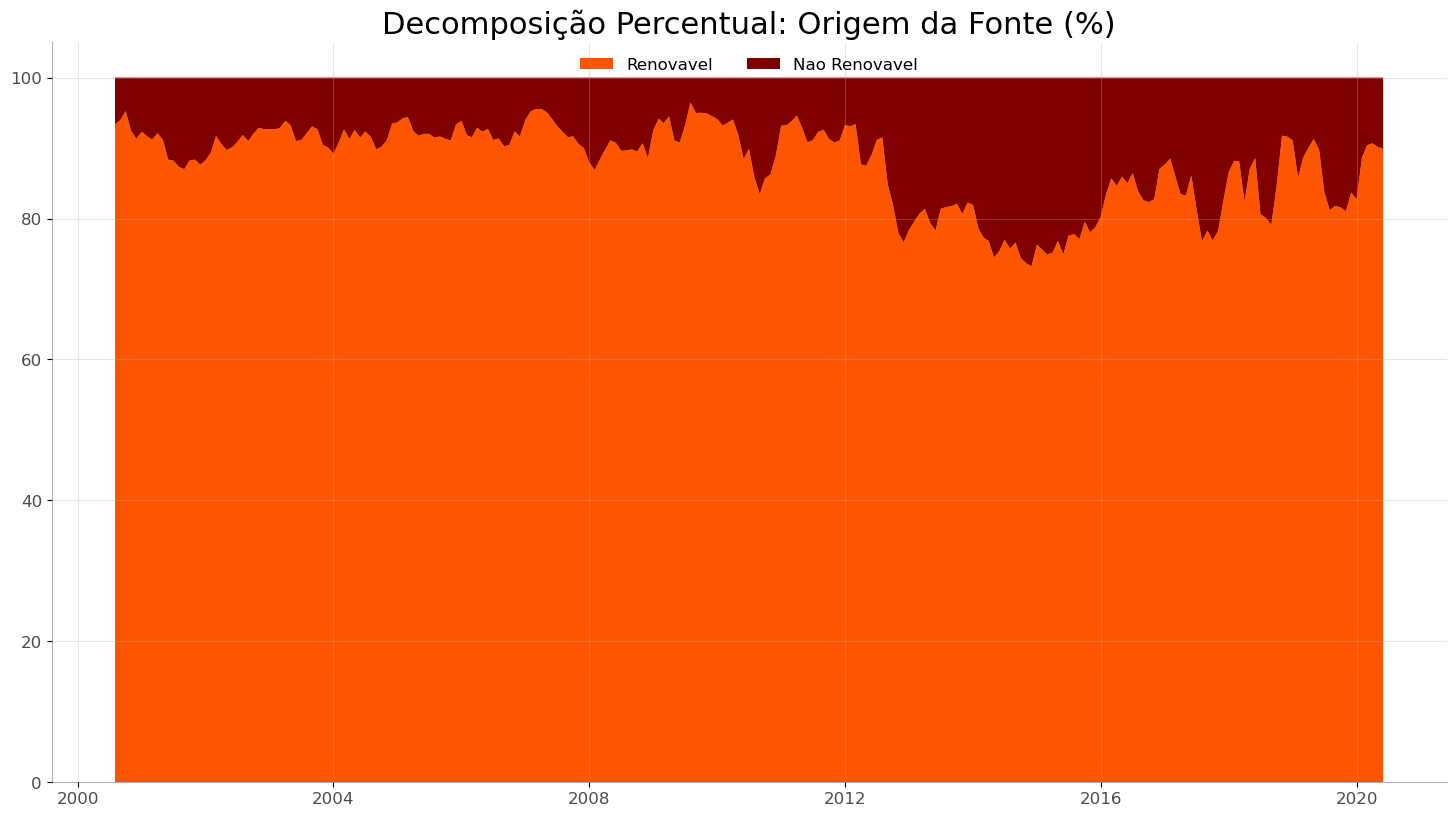

In [49]:
# Criação da variável que soma Energia Renovável e Não Renovável
origem = pd.DataFrame(dados_limpos['Total'] - dados_limpos['Residuos_Industriais'] - dados_limpos['Fora_do_SIN'], columns=['Origem da Fonte'])
selecao = dados_limpos[['Renovavel', 'Nao_Renovavel']]
ren_nao_ren_selecao = pd.concat([origem, selecao], axis=1)

# Criação do objeto referente à Classe "Graficos" de "Carvao"
ren_nao_ren_graficos = Graficos('origem', selecao, soma=None, soma_perc=None)

# Gráfico de Área que compara Energia Renovável com a Não Renovável
ren_nao_ren_graficos.areaplot(ren_nao_ren_selecao)

O Brasil é conhecido internacionalmente pela forte predominância de Fontes Renováveis na sua Matriz Elétrica, com destaque para o forte uso de Hidrelétricas. Entretanto, a forte dependência por essa fonte gerou problemas de garantia de fornecimento elétrico na Crise de 2001, incentivando a construção de Usinas Termelétricas para que essas fossem acionadas em momentos de crise hídrica. Entretanto, o uso de Termelétricas encarece a produção energética e aumenta fortemente os níveis de emissão de gás carbônico (CO2), o que contribui para o aumento do aquecimento global, causando problemas do ponto de vista econômico, social e ambiental. Portanto, a diversificação da Matriz Elétrica Brasileira deve ser feita de forma a maximizar a produção elétrica de forma a garantir a segurança no fornecimento de energia ao passo que minimiza a emissão de gases estufa.

O gráfico acima demonstra que a participação de Fontes Renováveis - que superou os 90% em muitos momentos - caiu para valores abaixo de 80% em meados da década de 2010. Entretanto, desde o final da década de 2010 tem ocorrido um grande aumento no uso de Fontes Renováveis, se aproximando do patamar observado no começo do século em seus pontos de máximo. Dessa forma, é importante observar com mais detalhes a composição da Energia Renovável no Brasil através do século XXI.

In [50]:
# Criação do objeto referente à Classe "Graficos" de "Renovável"
renovavel_graficos = Graficos('Renovavel', dados_limpos, soma, soma_perc)

# Seleção das variáveis do agrupamento
renovavel_selecao = dados_limpos[['Renovavel', 'Hidreletricas_exceto_Itaipu', 'Itaipu', 'Eolicas', 'Biomassas', 'Solar_Fotovoltaica']]

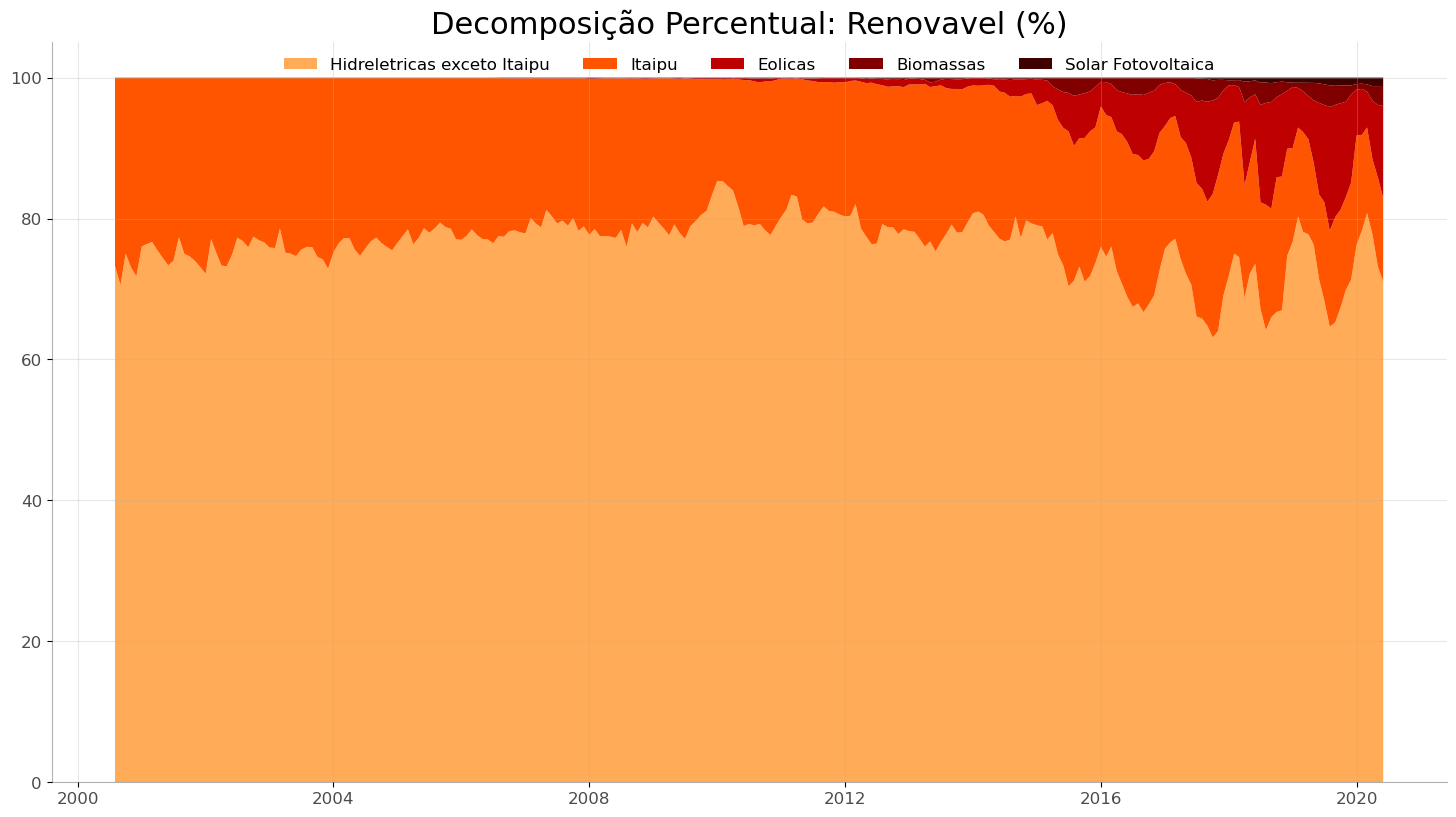

In [51]:
# Gráfico de Área para o Agrupamento "Renovável"
renovavel_graficos.areaplot(renovavel_selecao)

O agrupamento Renovável foi completamente tomado por Fontes Hidrelétricas pela década de 2000, passando a possuir a participação de outras fontes no SIN no começo da década de 2010. No final do período nota-se que a predominância das Hidrelétricas diminui, com destaque para a o crescimento da fonte Eólica. É interessante observar que os pontos de máximo de produção Eólica fazem com que a participação das demais fontes caiam fortemente no agrupamento, de forma que "Hidrelétricas (exceto Itaipu)" chegue a obter participação de apenas pouco mais de 60% dentre as Fontes Renováveis, demonstrando a recente diversificação na Matriz Elétrica.

Portanto, essa análise demonstrou como se desenvolveu a Matriz Elétrica Brasileira e as principais mudanças na sua composição. No momento, com uma Matriz Elétrica mais diversificada e com o uso cada vez menor de fontes menos renováveis, o desafio se concentra em como acelerar a implementação dessas fontes na matriz. Entretanto, deve-se buscar formas de minimizar o impacto dessas fontes na segurança do fornecimento energético, visto que as Fontes Eólica e Solar Fotovoltaica são intermitentes, o que pode acarretar em oscilações no fornecimento de energia. 

## 5. ANÁLISE DE SÉRIES TEMPORAIS

Uma Série Temporal pode ser decomposta em dois parâmetros a fim de facilitar sua análise: trend(tendência) e seasonal(sazonalidade), onde:
 - Tendência: Indica o comportamento da variável ao passar do tempo, percebendo o crescimento, queda ou estabilidade da série.
 - Sazonalidade: Avalia as variações que ocorrem em um mesmo ciclo temporal, podendo ser ele diário (ciclo de 24 horas), semanal (ciclo de 7 dias), anual (ciclo de 12 meses), entre outros.

Dessa forma, será plotado um conjunto de gráficos para avaliar esses parâmetros para a Série Temporal em análise, além dos resíduos, que indicam o valor restante da variável após a decomposição da série em tendência e sazonalidade.

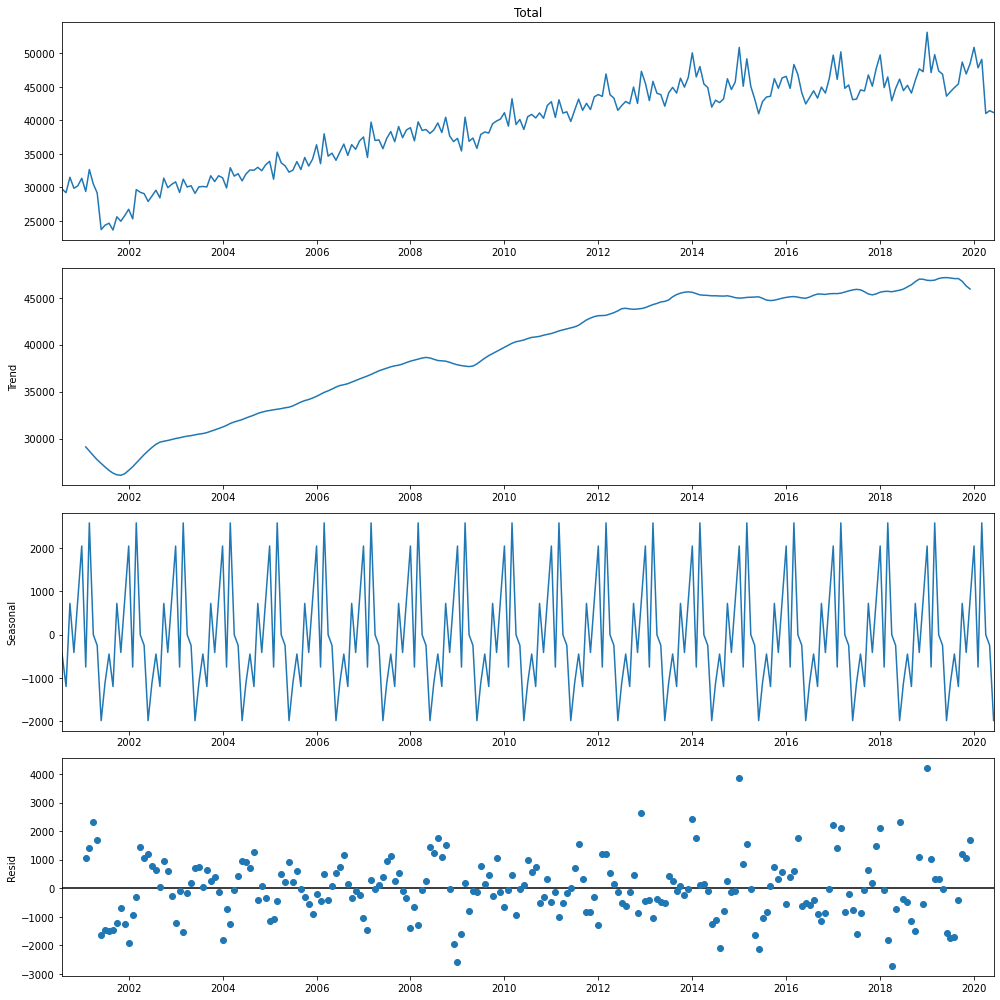

In [52]:
# Definição do objeto da classe "Sarima" para "Total"
total_sarima = Sarima(dados_limpos, 'Total')

# Decomposição da Série Temporal
total_sarima.decomposicao_sazonal()

A decomposição mostra uma tendência de crescimento até 2014, com exceção do período entre 2001 e 2002 (Crise Hídrica e racionamento de energia) e 2009 (Crise Econômica Mundial). De 2015 em diante nota-se uma tendência à estacionariedade, com variações relativamente pequenas. A sazonalidade demonstrada pelo gráfico coincide com aquela indicada pelo "boxplot" mensal, com ápices em janeiro e março e vales maiores no meio do ano, com destaque pra junho. Os resíduos tendem a se manter próximos à zero, entretanto, há um elevado nível de dispersão, principalmente para os últimos dados da Série Temporal.

### 5.1. Testes Estatísticos de Estacionariedade

O Teste Aumentado de Dickey-Fuller é uma versão mais complexa do teste Dickey-Fuller, tendo como objetivo a determinação da existência de uma raiz unitária em um modelo autorregressivo. A presença da raiz unitária - representada por alfa (α) - indica que a série é não estacionária, onde sua presença é indicada a partir de um teste de hipótese nula que assuma a sua existência. A estatística desse teste é indicada por um valor negativo, que, quanto mais negativo ele for, maior a confiança na rejeição da hipótese apresentada. O resultado de p-valor menor que 0,05 - indicando significância de até 5% - indicará a rejeição da hipótese de que a série é não estacionária. 


   | p-valor | Hipótese |
   |:------:|:------:|
   |   p < 0.05  | H0: Série não estacionária | 
   |   p >= 0.05  | H1 : Série estacionária |

A função que representa esse teste é mostrada abaixo. 

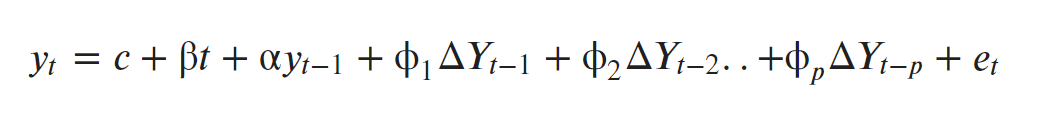

O Teste Kwiatkowski-Phillips-Schmidt-Shin (KPSS) se assemelha com o Teste ADF por também se tratar de um teste de raiz unitária, indicando se a série possui tendência estacionária. Entretanto, diferentemente do ADF, a hipótese nula do Teste KPSS presume a estacionariedade da série, logo, um p < 0.05 indica que a série possui tendência estacionária.

   | p-valor | Hipótese |
   |:------:|:------:|
   |   p < 0.05  | H0: Série possui tendência estacionária | 
   |   p >= 0.05  | H1 : Série não possui tendência estacionária |

In [53]:
# Realização dos Testes ADF e KPSS com nenhuma diferenciação
total_sarima.adf_kpss(0)

,Fonte de Energia,ADF,P-Valor ADF,Estacionário ADF,KPSS,P-Valor KPSS,Estacionário KPSS
0,Total,-2.287699,0.175966,False,2.127527,0.01,False


Como os dois testes indicam que a série não é estacionária, será necessária a realização de pelo menos uma diferenciação como forma de fazer a série se tornar estacionária.

In [54]:
# Realização dos Testes ADF e KPSS com 1 (uma) diferenciação
total_sarima.adf_kpss(1)

,Fonte de Energia,ADF,P-Valor ADF,Estacionário ADF,KPSS,P-Valor KPSS,Estacionário KPSS
0,Total,-5.804598,4.547433e-07,True,0.070501,0.1,True


Portanto, uma diferenciação é suficiente para que a série seja estacionária. O número de diferenciações é um parâmetro importante para o modelo SARIMA, que será aplicado para modelagem da série. Esse modelo e seus parâmetros serão explicados a seguir.

### 5.2. Modelo SARIMA

O modelo SARIMA (Seasonal Auto Regressive Integrated Moving Average) é uma junção de diferentes modelos para a modelagem de Séries Temporais, onde:
 - AR: Se refere ao Modelo Autorregressivo, que usa valores antigos da Série Temporal para a criação do modelo preditivo;
 - MA: Refere-se ao Modelo de Médias Móveis (Moving Average), que usa valores antigos do resíduo para a criação do modelo;
 - I: Indica o fator de diferenciação entre os dados da Série Temporal;
 - S: Permite a inclusão de parâmetros extras ao modelo ARIMA para mensurar o impacto da sazonalidade nos valores da Série Temporal.

O modelo SARIMA é formado pela inclusão de parâmetros extras ao modelo ARIMA que permite a mensuração de sazonalidade nos dados. Dessa forma, o modelo se estrutura na forma SARIMA(p,d,q)(P,Q,D,S), onde:

 - p: Indica o número de "lags" do modelo Autorregressivo;
 - d: Indica o número de diferenciações;
 - q: Indica o número de "lags" do modelo de Médias Móveis;
 - P: Ordem de Autorregressão sazonal;
 - D: Ordem de diferenciação sazonal;
 - Q: Ordem de Médias Móveis sazonal;
 - S: Tamanho do "lag" de sazonalidade.

Desse modo, um modelo SARIMA será criado para prever o comportamento da Energia Total nos próximos 12 meses. Para tentar obter o melhor conjunto de parâmetros desse conjunto de dados, será realizado um "grid search", onde será feita uma varredura de todos as combinações dos parâmetros SARIMA(p,d,q)(P,Q,D,S) possíveis. O melhor conjunto será definido ao escolher aquele que possui o menor valor de AIC (critério de informação de Akaike), que mensura a qualidade e simplicidade de um modelo estatístico.

Como os testes estatísticos de estacionariedade indicaram a necessidade de apenas uma diferenciação, os parâmetros "d" e "D" serão fixados em 1. Já os parâmetros "p", "q", "P" e "Q" irão ter seus valores variando entre 0 e 4. Como é um modelo anual, o valor de "S" será fixado em 12.

O modelo será treinado em um dataset de treino que contém os 197 primeiros valores do conjunto de dados (agosto/2000 até dezembro/2016) para posterior validação do modelo com os dados restantes.

In [55]:
# Melhores parâmetros para o modelo SARIMA
total_sarima.modelo_sarima()

Tempo gasto para calcular os melhores parâmetros: 3197.12 segundos


,pdq,pdq_sazonal,aic
545,"(4, 1, 1)","(4, 1, 0, 12)",2217.027023


A combinação SARIMA(4,1,1)(4,1,0,12) foi aquela que obteve o menor valor de AIC dentre aqueles que demonstravam um resultado significativamente válido, eliminando combinações que tivessem valores de AIC muito baixos mas que retornassem resultados impossíveis de serem utilizados. Nota-se que foram gastos 3197 segundos (mais de 53 minutos) para rodar esse programa, o que demonstra o alto consumo computacional necessário para a realização de um "grid search".

                                      SARIMAX Results                                      
Dep. Variable:                               Total   No. Observations:                  197
Model:             SARIMAX(4, 1, 1)x(4, 1, [], 12)   Log Likelihood               -1098.514
Date:                             Thu, 03 Mar 2022   AIC                           2217.027
Time:                                     00:03:39   BIC                           2245.855
Sample:                                 08-01-2000   HQIC                          2228.741
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4490      0.112      4.011      0.000       0.230       0.668
ar.L2          0.1964      

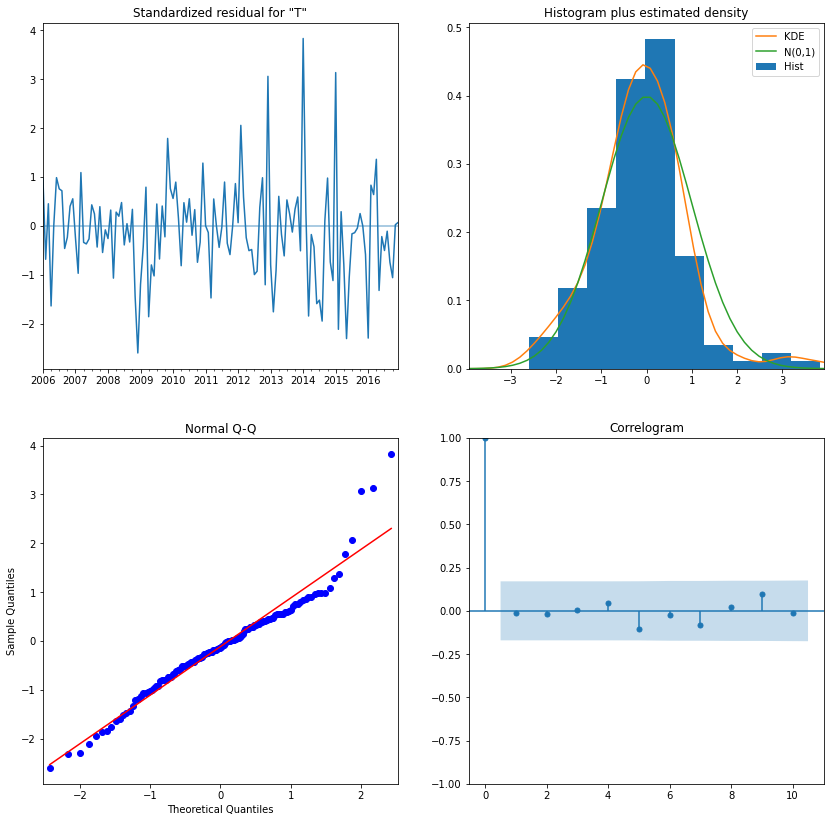

In [56]:
# Sumário e gráficos de diagnóstico dos resultados do modelo
total_sarima.sumario()

A partir do sumário dos resultados, nota-se que a Prob(Q) referente ao Teste Ljung-Box é maior que 0,05, o que mostra que os resíduos não são correlacionados, o que é o desejável. Como o conjunto de dados possui um valor de entradas inferior à 2000, não é possível usar o Teste de Jarque-Bera para avaliar se a distribuição dos resíduos se assemelha à de uma normal.

A partir do gráfico de "Standardized residual" (1,1) (resíduos padronizados) percebe-se que não há uma tendência muito bem estabelecida na sua distribuição, embora haja uma quantidade relevante de cristas e vales.

O Histograma KDE dos resíduos (1,2) mostra que sua distribuição se assemelha à uma distribuição normal, embora haja uma certa distorção, principalmente referente aos últimos dados do histograma, que mostra uma crista que faz com que ele se afaste de um comportamento normal.

O Gráfico Q-Q (2,1) reforça essa tendência, visto que os resíduos se comportam normalmente até a parte final do conjunto de dados, onde há um afastamento significativo, demonstrado pelos pontos muito acima da linha vermelha e pela quantidade alta de pontos abaixo da linha vermelha.

O Correlograma ACF (ACF Plot) (2,2) mostra que os "lags" não são significativos, permanecendo dentro da área azul, o que é o desejado.

In [57]:
# Métricas de validação do modelo
total_sarima.acuracia()

,Raiz do Erro Quadrático Médio,Raiz do Erro Quadrático Médio Normalizado,Erro Percentual Absoluto Médio (%)
modelo,1755.059955,0.145135,2.664028


As medidas de validação do modelo com melhor AIC mostram um REQM relativamente baixo ao considerar a magnitude dos dados, resultando num REQM Normalizado de 0,14. Já o EPAM foi de apenas 2,66%, sendo um resultado bem satisfatório. 

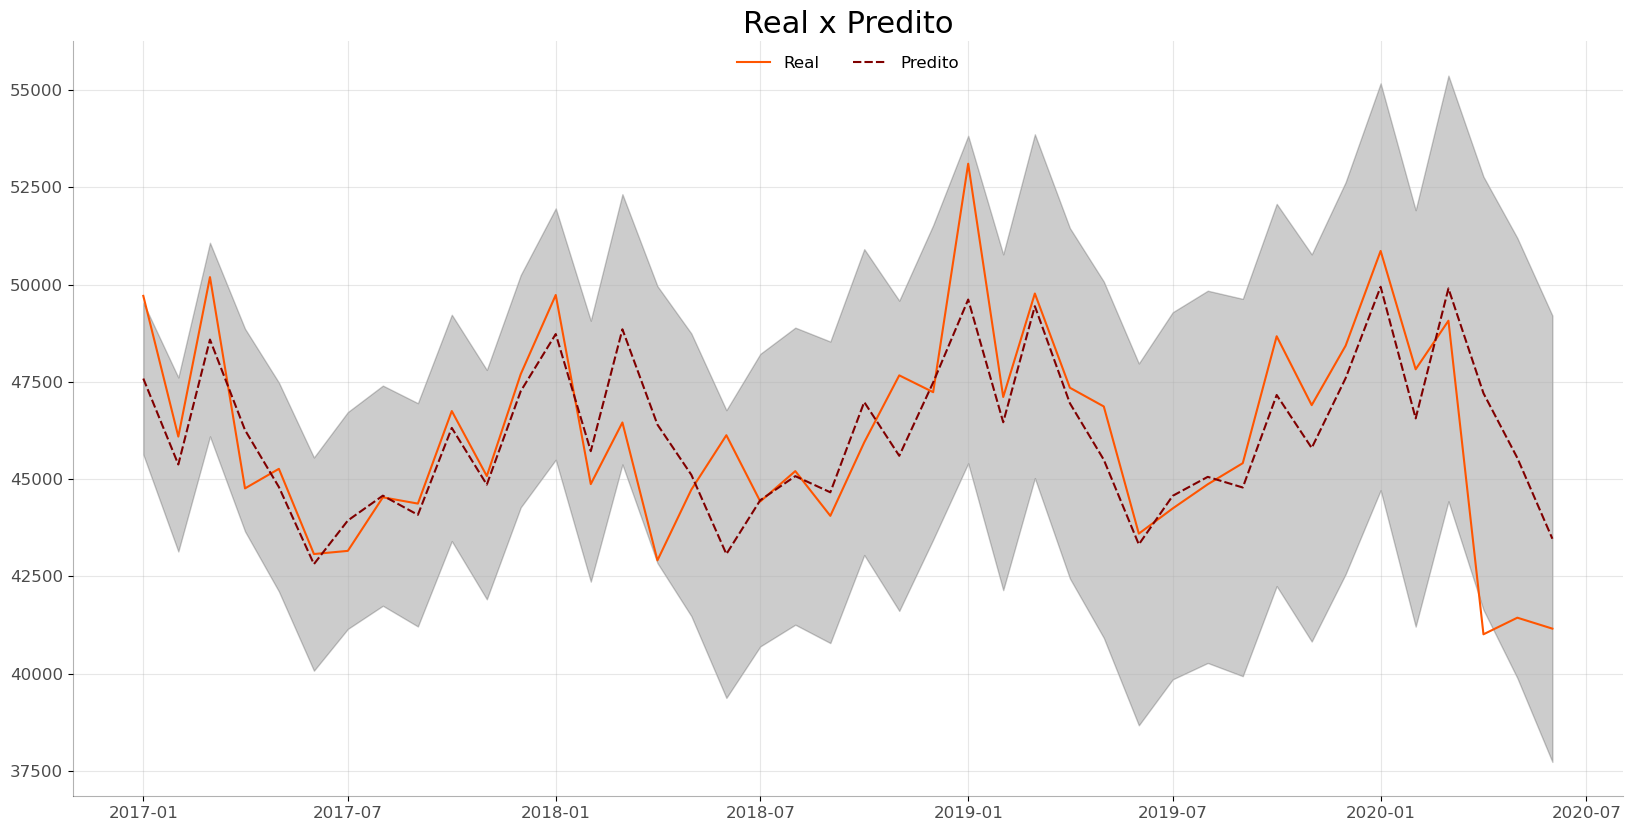

In [58]:
# Gráfico de comparação entre o dataset de teste (real) e o predito pelo modelo
total_sarima.predicao_grafico()

O gráfico acima compara os dados do conjunto de dados de teste com aqueles previstos pelo modelo calculado. Como as medidas de validação demonstraram, o modelo se comporta de forma muito satisfatória ao prever resultados que ele nunca viu, visto que apenas um dos resultados "fugiu" do intervalo de confiança de 95%, sendo esse um dado que obteve um comportamento anormalmente baixo para o período. Logo, os resultados acima confirmam a capacidade preditiva do modelo, que agora será utilizado para prever os próximos 12 meses da Energia Total, com toda Série Histórica e o intervalo de confiança para a previsão.

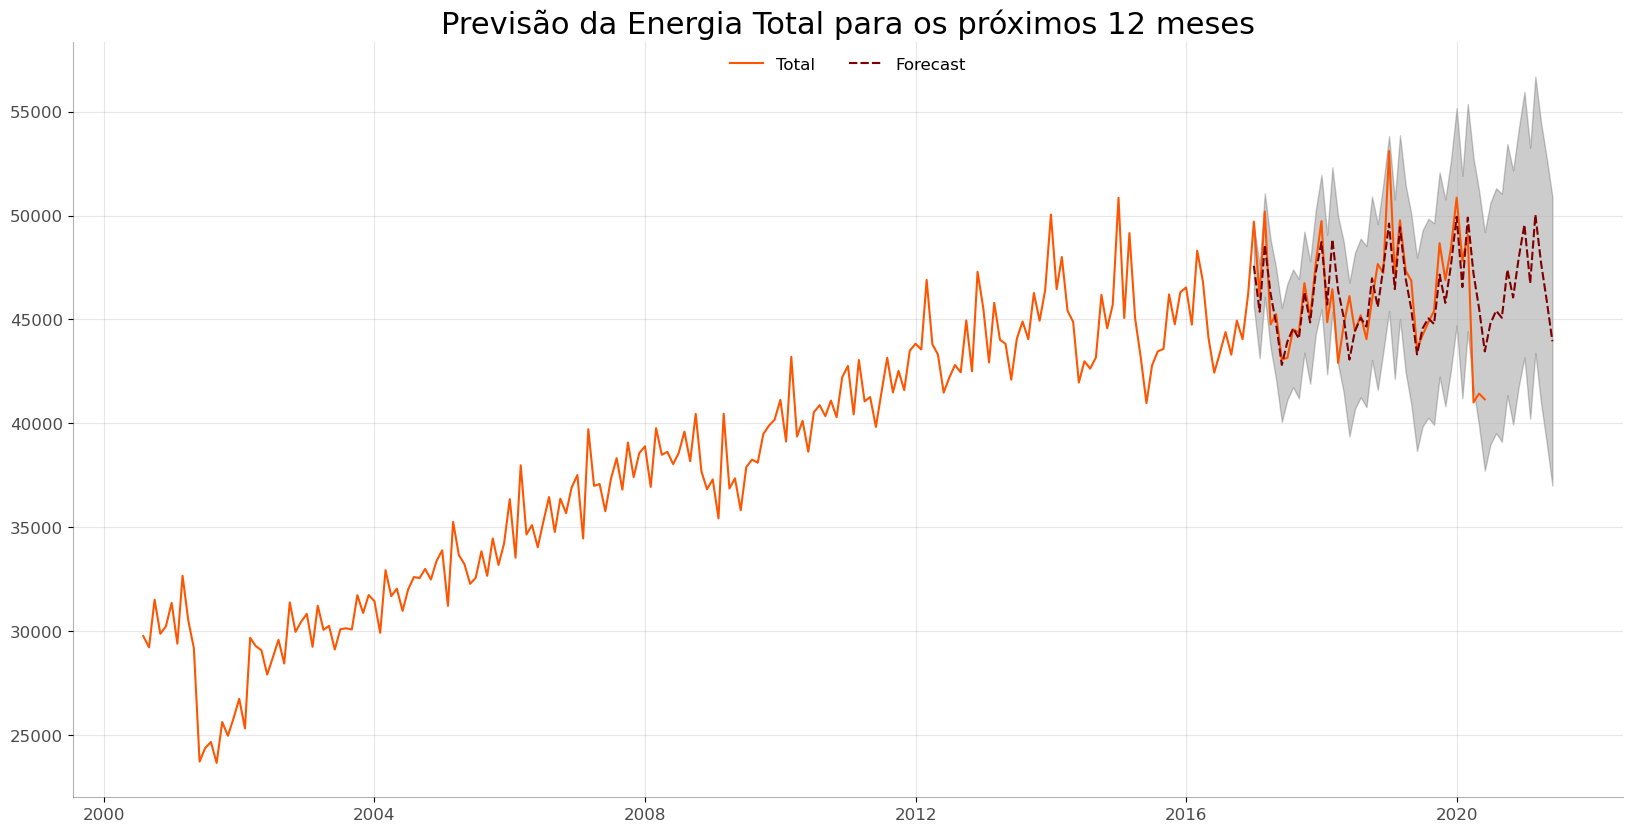

In [59]:
# Previsão do comportamento de Energia Total para os 12 meses subsequentes 
total_sarima.forecast_grafico()

# CONCLUSÃO 

Assim, a Análise da Energia Elétrica Brasileira entre 2000 e 2020 foi finalizada. Nesse projeto:
- Foi feita a obtenção dos dados através dos Dados Abertos disponibilizados pelo Governo Federal, seu tratamento e manipulação, que facilitaram a posterior análise.
- Discutiu-se sobre os motivos que causaram o comportamento das diferentes variáveis na Análise Exploratória de Dados, mostrando o impacto de políticas governamentais e crises ambientais e econômicas na produção energética.
- Concluiu-se que a Energia Elétrica Brasileira tem visto uma expansão no uso de Energias Renováveis que não sejam de origem hídrica, o que minimiza as emissões de gases estufa e diminui o efeito que uma crise hídrica pode causar no fornecimento de energia para a população. Entretanto essa política pode gerar impactos pelo aumento no uso de fontes intermitentes na Matriz Elétrica;
- Foi realizada uma análise da Série Temporal da Energia Total Despachada, decompondo seus componentes e foi criado um modelo preditivo para seu comportamento nos próximos 12 meses.

Se quiser tirar alguma dúvida, fazer alguma sugestão ou conversar sobre o projeto, entre em contato comigo pelo meu [LinkedIn](https://www.linkedin.com/in/luanrdutra/). Também aproveite e veja o que eu tenho feito no meu [GitHub](https://github.com/LuanRD).

Obrigado pela atenção :D 